In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Time Series Modeling

## Decomposing time series

1. Import the lbraries:

In [3]:
!pip install quandl

In [4]:
import pandas as pd
import quandl
from statsmodels.tsa.seasonal import seasonal_decompose

2. Download the prices of gold for years 2000-2011 and resample to monthly values:

In [5]:
QUANDL_KEY = '15L4ky9aN_bF_6uss8CA' # replace {key} with your own API key  
quandl.ApiConfig.api_key = QUANDL_KEY

df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
               start_date='2000-01-01', 
               end_date='2011-12-31')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()

In [6]:
print(f'Shape of DataFrame: {df.shape}')
df.head()

Shape of DataFrame: (144, 1)


price
Date              
2000-01-31  284.31
2000-02-29  299.86
2000-03-31  286.39
2000-04-30  279.69
2000-05-31  275.19

3. Add rolling mean and standard deviation:

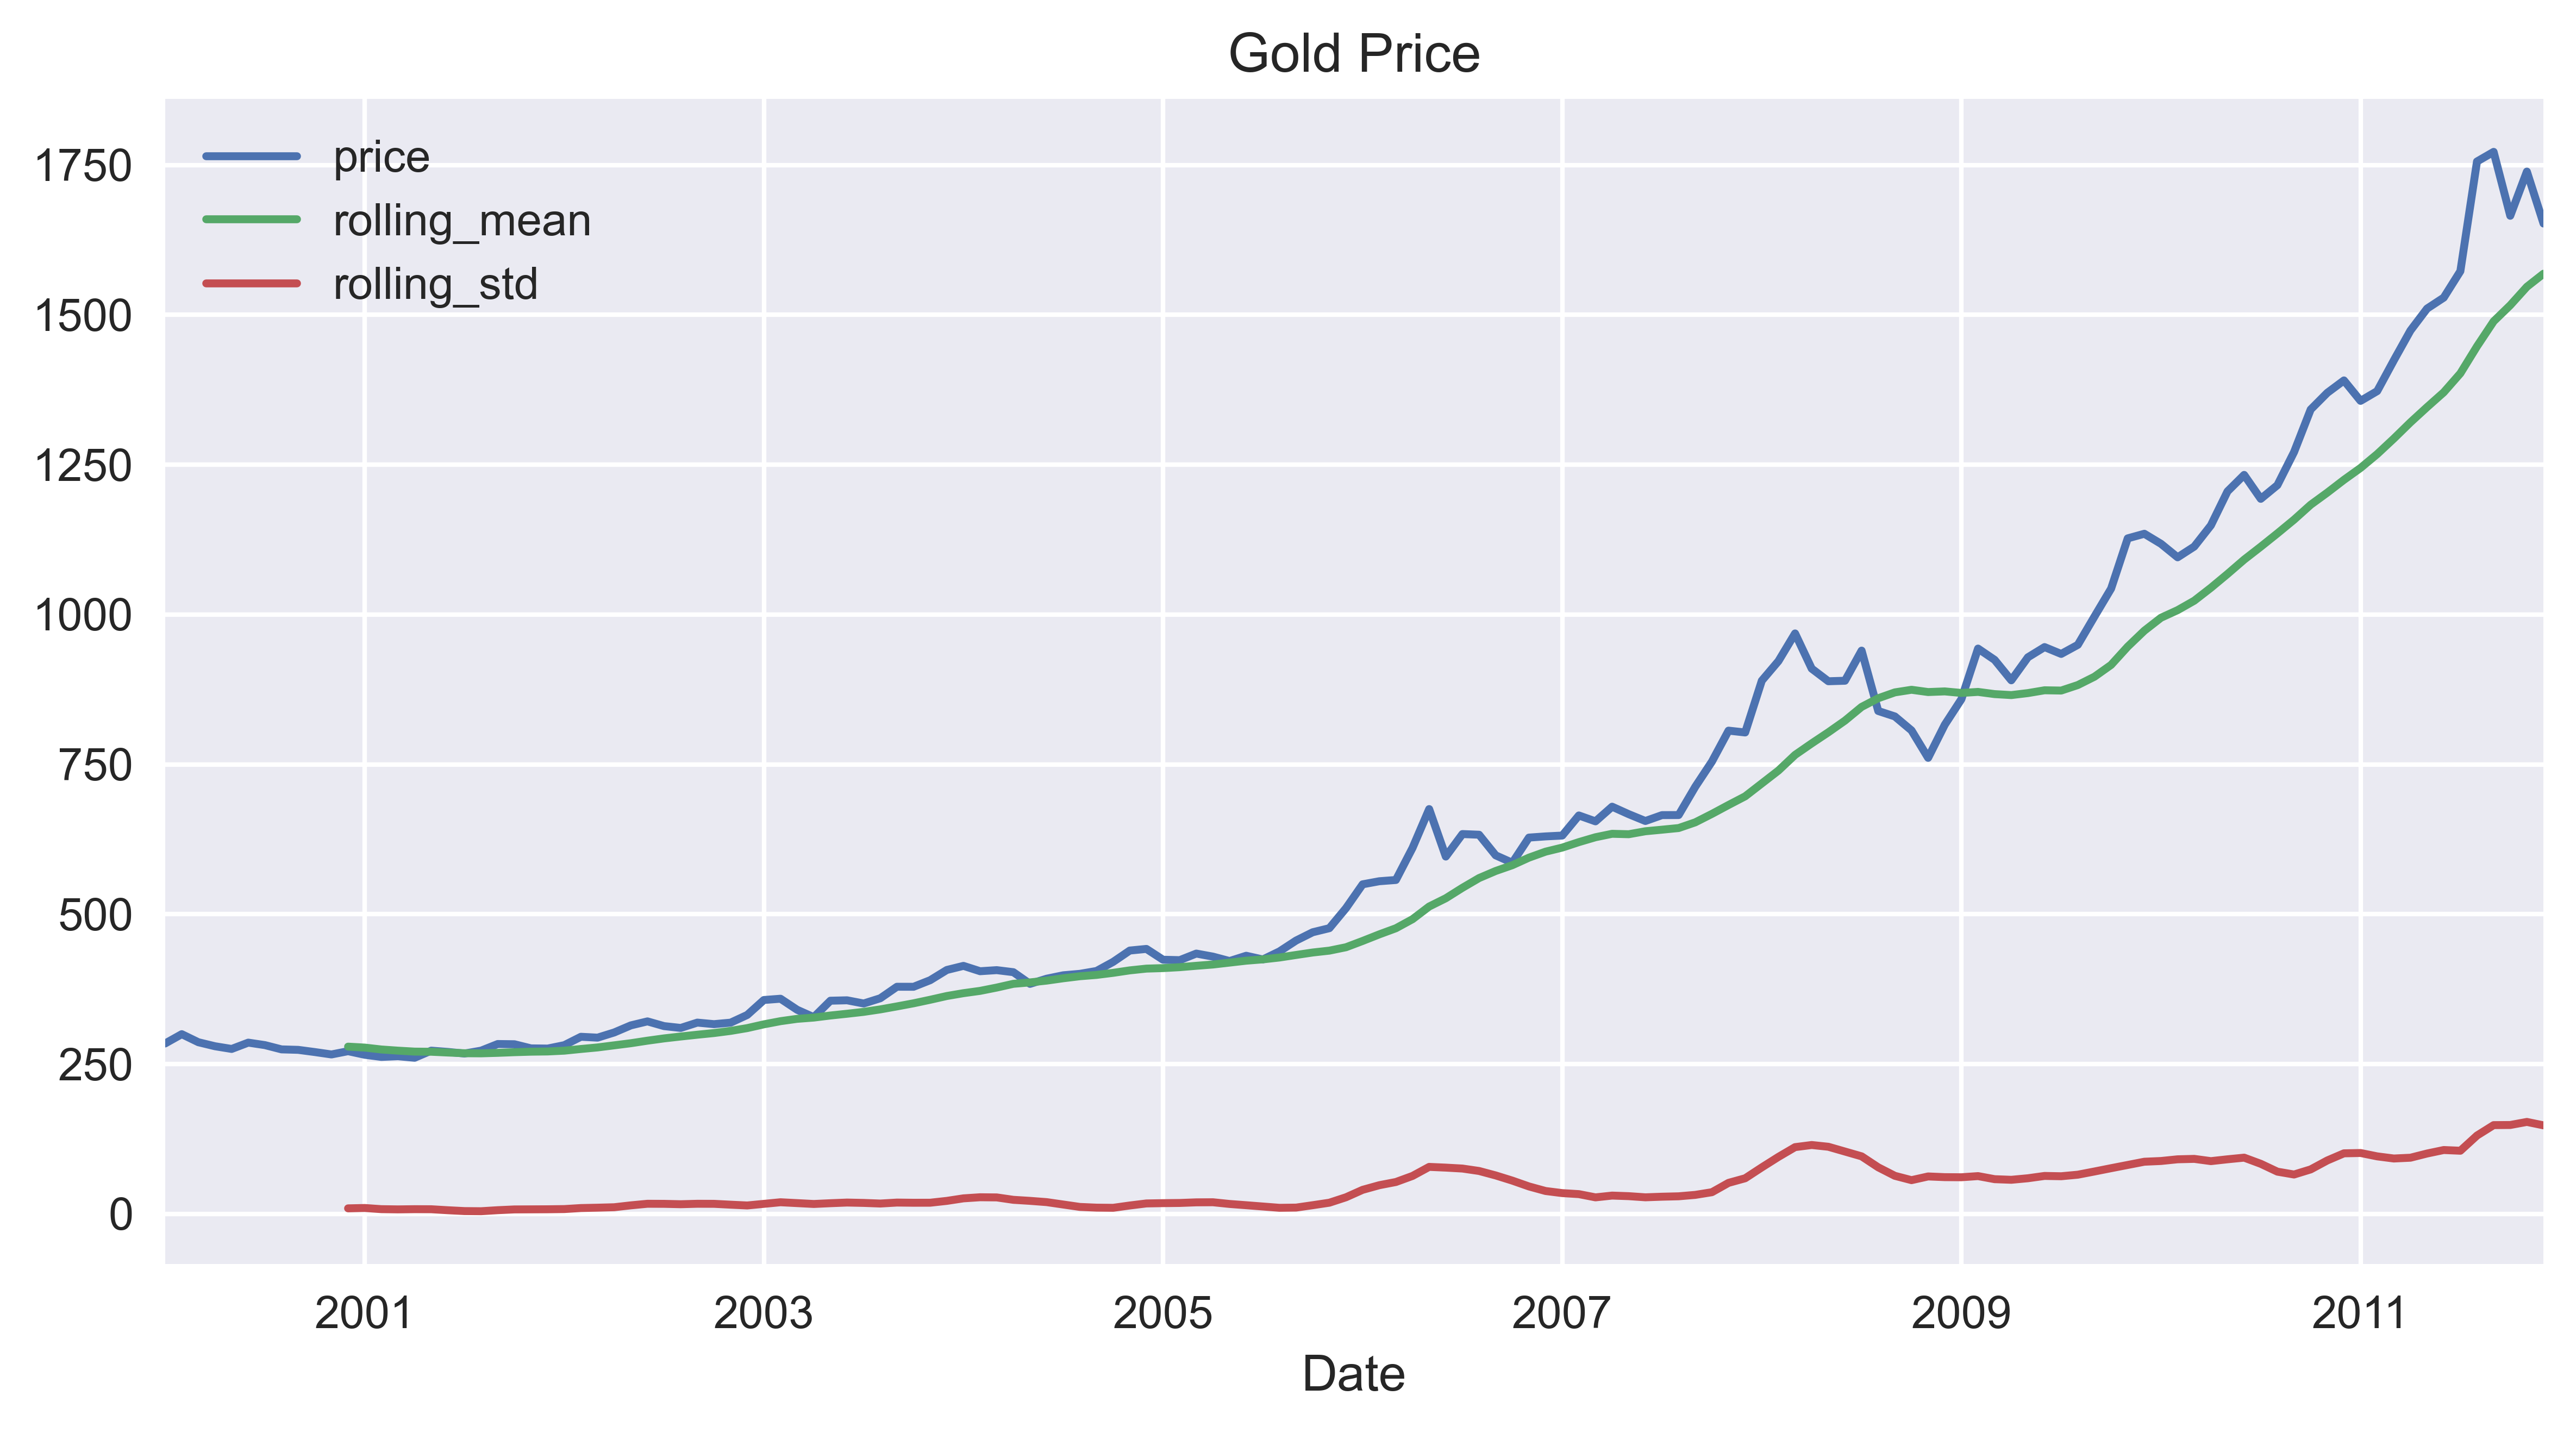

In [7]:
WINDOW_SIZE = 12
df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()
df.plot(title='Gold Price')

plt.tight_layout()
plt.show()

4. Carry out seasonal decomposition using the multiplicative model:

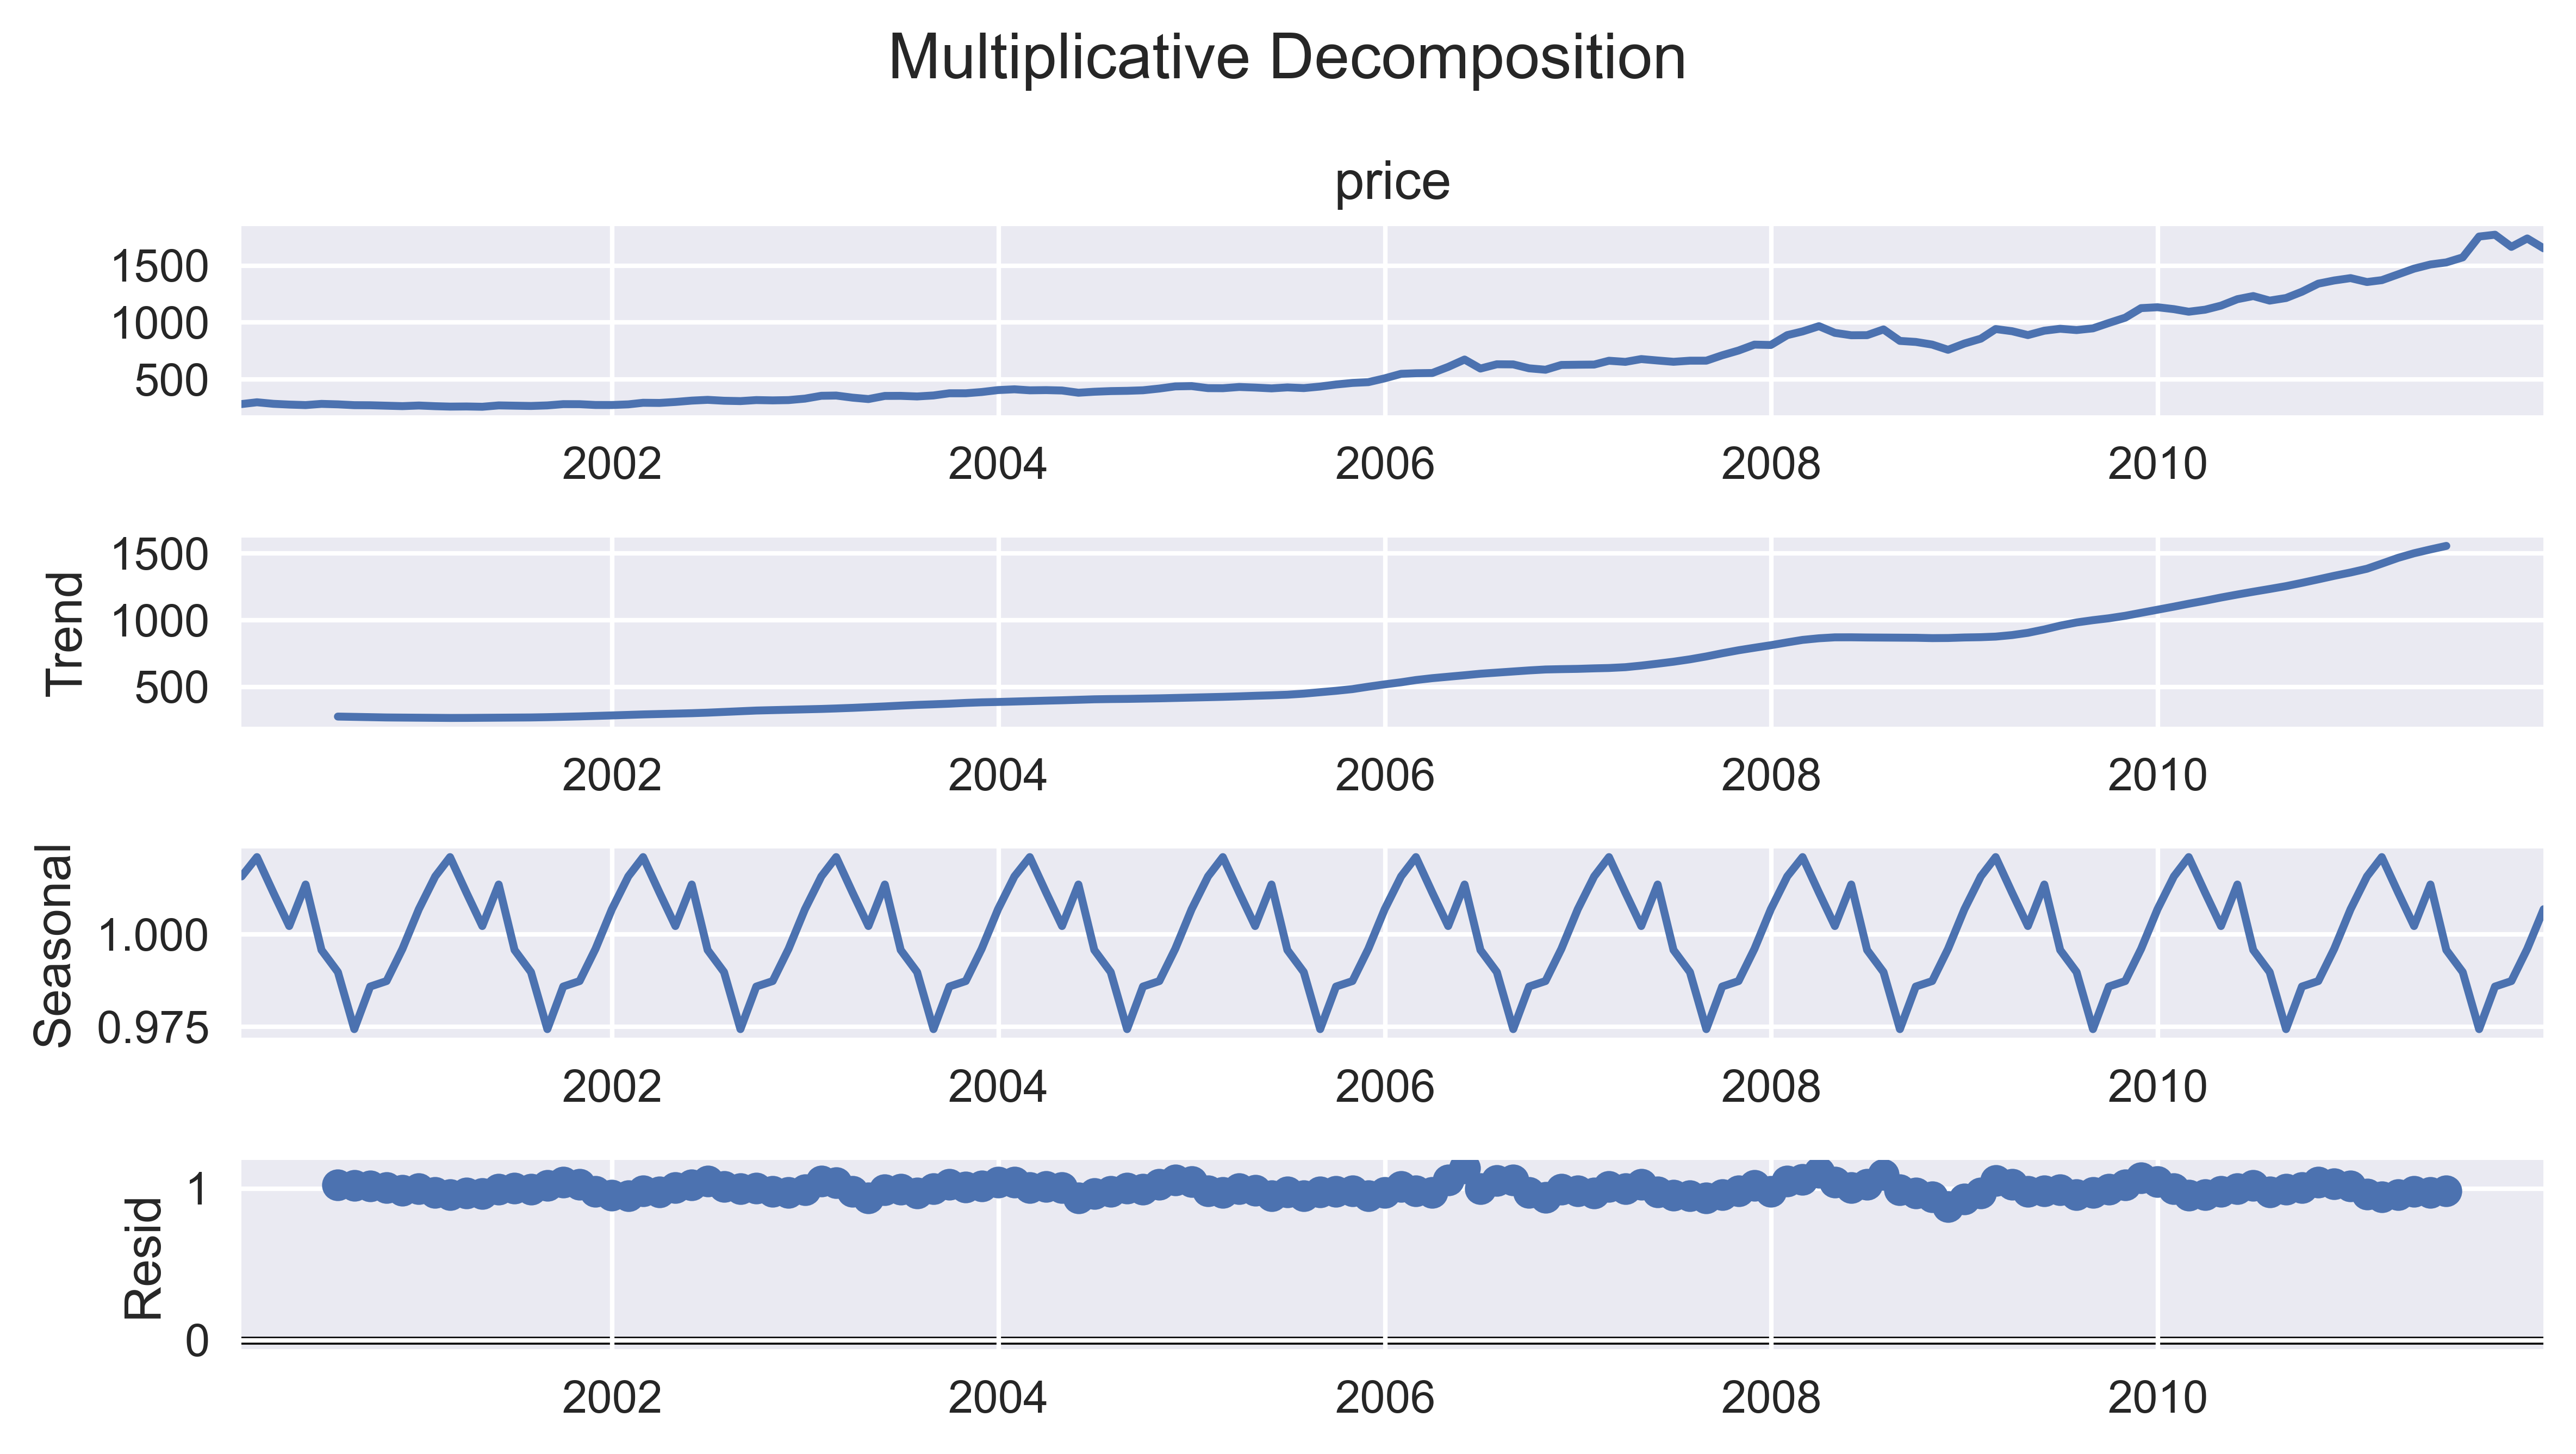

In [8]:
decomposition_results = seasonal_decompose(df.price, 
                                          model='multiplicative')
decomposition_results.plot() \
                     .suptitle('Multiplicative Decomposition',
                              fontsize=14)

plt.tight_layout()
plt.show()

## Testing for stationarity in time series

0: Download the data:

In [9]:
import pandas as pd
import quandl

In [10]:
QUANDL_KEY = '15L4ky9aN_bF_6uss8CA' # replace {key} with your own API key  
quandl.ApiConfig.api_key = QUANDL_KEY

df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
               start_date='2000-01-01', 
               end_date='2011-12-31')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()

1. Import the libraries:

In [11]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

2. Define a function for running the ADF test:

In [12]:
def adf_test(x):
    '''
    Function for performing the Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary
    
    Parameters
    ----------
    x : pd.Series / np.array
    The time series to be checked for stationarity
    
    Returns
    -------
    results: pd.DataFrame
    A DataFrame with the ADF test's results
    '''
    
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']
    
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    
    return results

In [13]:
adf_test(df.price)

Test Statistic              3.510499
p-value                     1.000000
# of Lags Used             14.000000
# of Observations Used    129.000000
Critical Value (1%)        -3.482088
Critical Value (5%)        -2.884219
Critical Value (10%)       -2.578864
dtype: float64

3. Define a function for running the KPSS test:

In [14]:
def kpss_test(x, h0_type='c'):
    '''
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
    
    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary
    
    Parameters
    ----------
    x: pd.Series / np.array
    The time series to be checked for stationarity
    h0_type: str{'c', 'ct'}
    Indicates the null hypothesis of the KPSS test:
    * 'c': The data is stationary around a constant(default)
    * 'ct': The data is stationary around a trend
        
    Returns
    -------
    results: pd.DataFrame
    A DataFrame with the KPSS test's results
    '''
            
    indices = ['Test Statistic', 'p-value', '# of Lags']
            
    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
            
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
            
    return results

In [15]:
kpss_test(df.price)

C:\Users\cti110016\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


Test Statistic            0.985671
p-value                   0.010000
# of Lags                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

4. Generate the ACF/PACF plots:

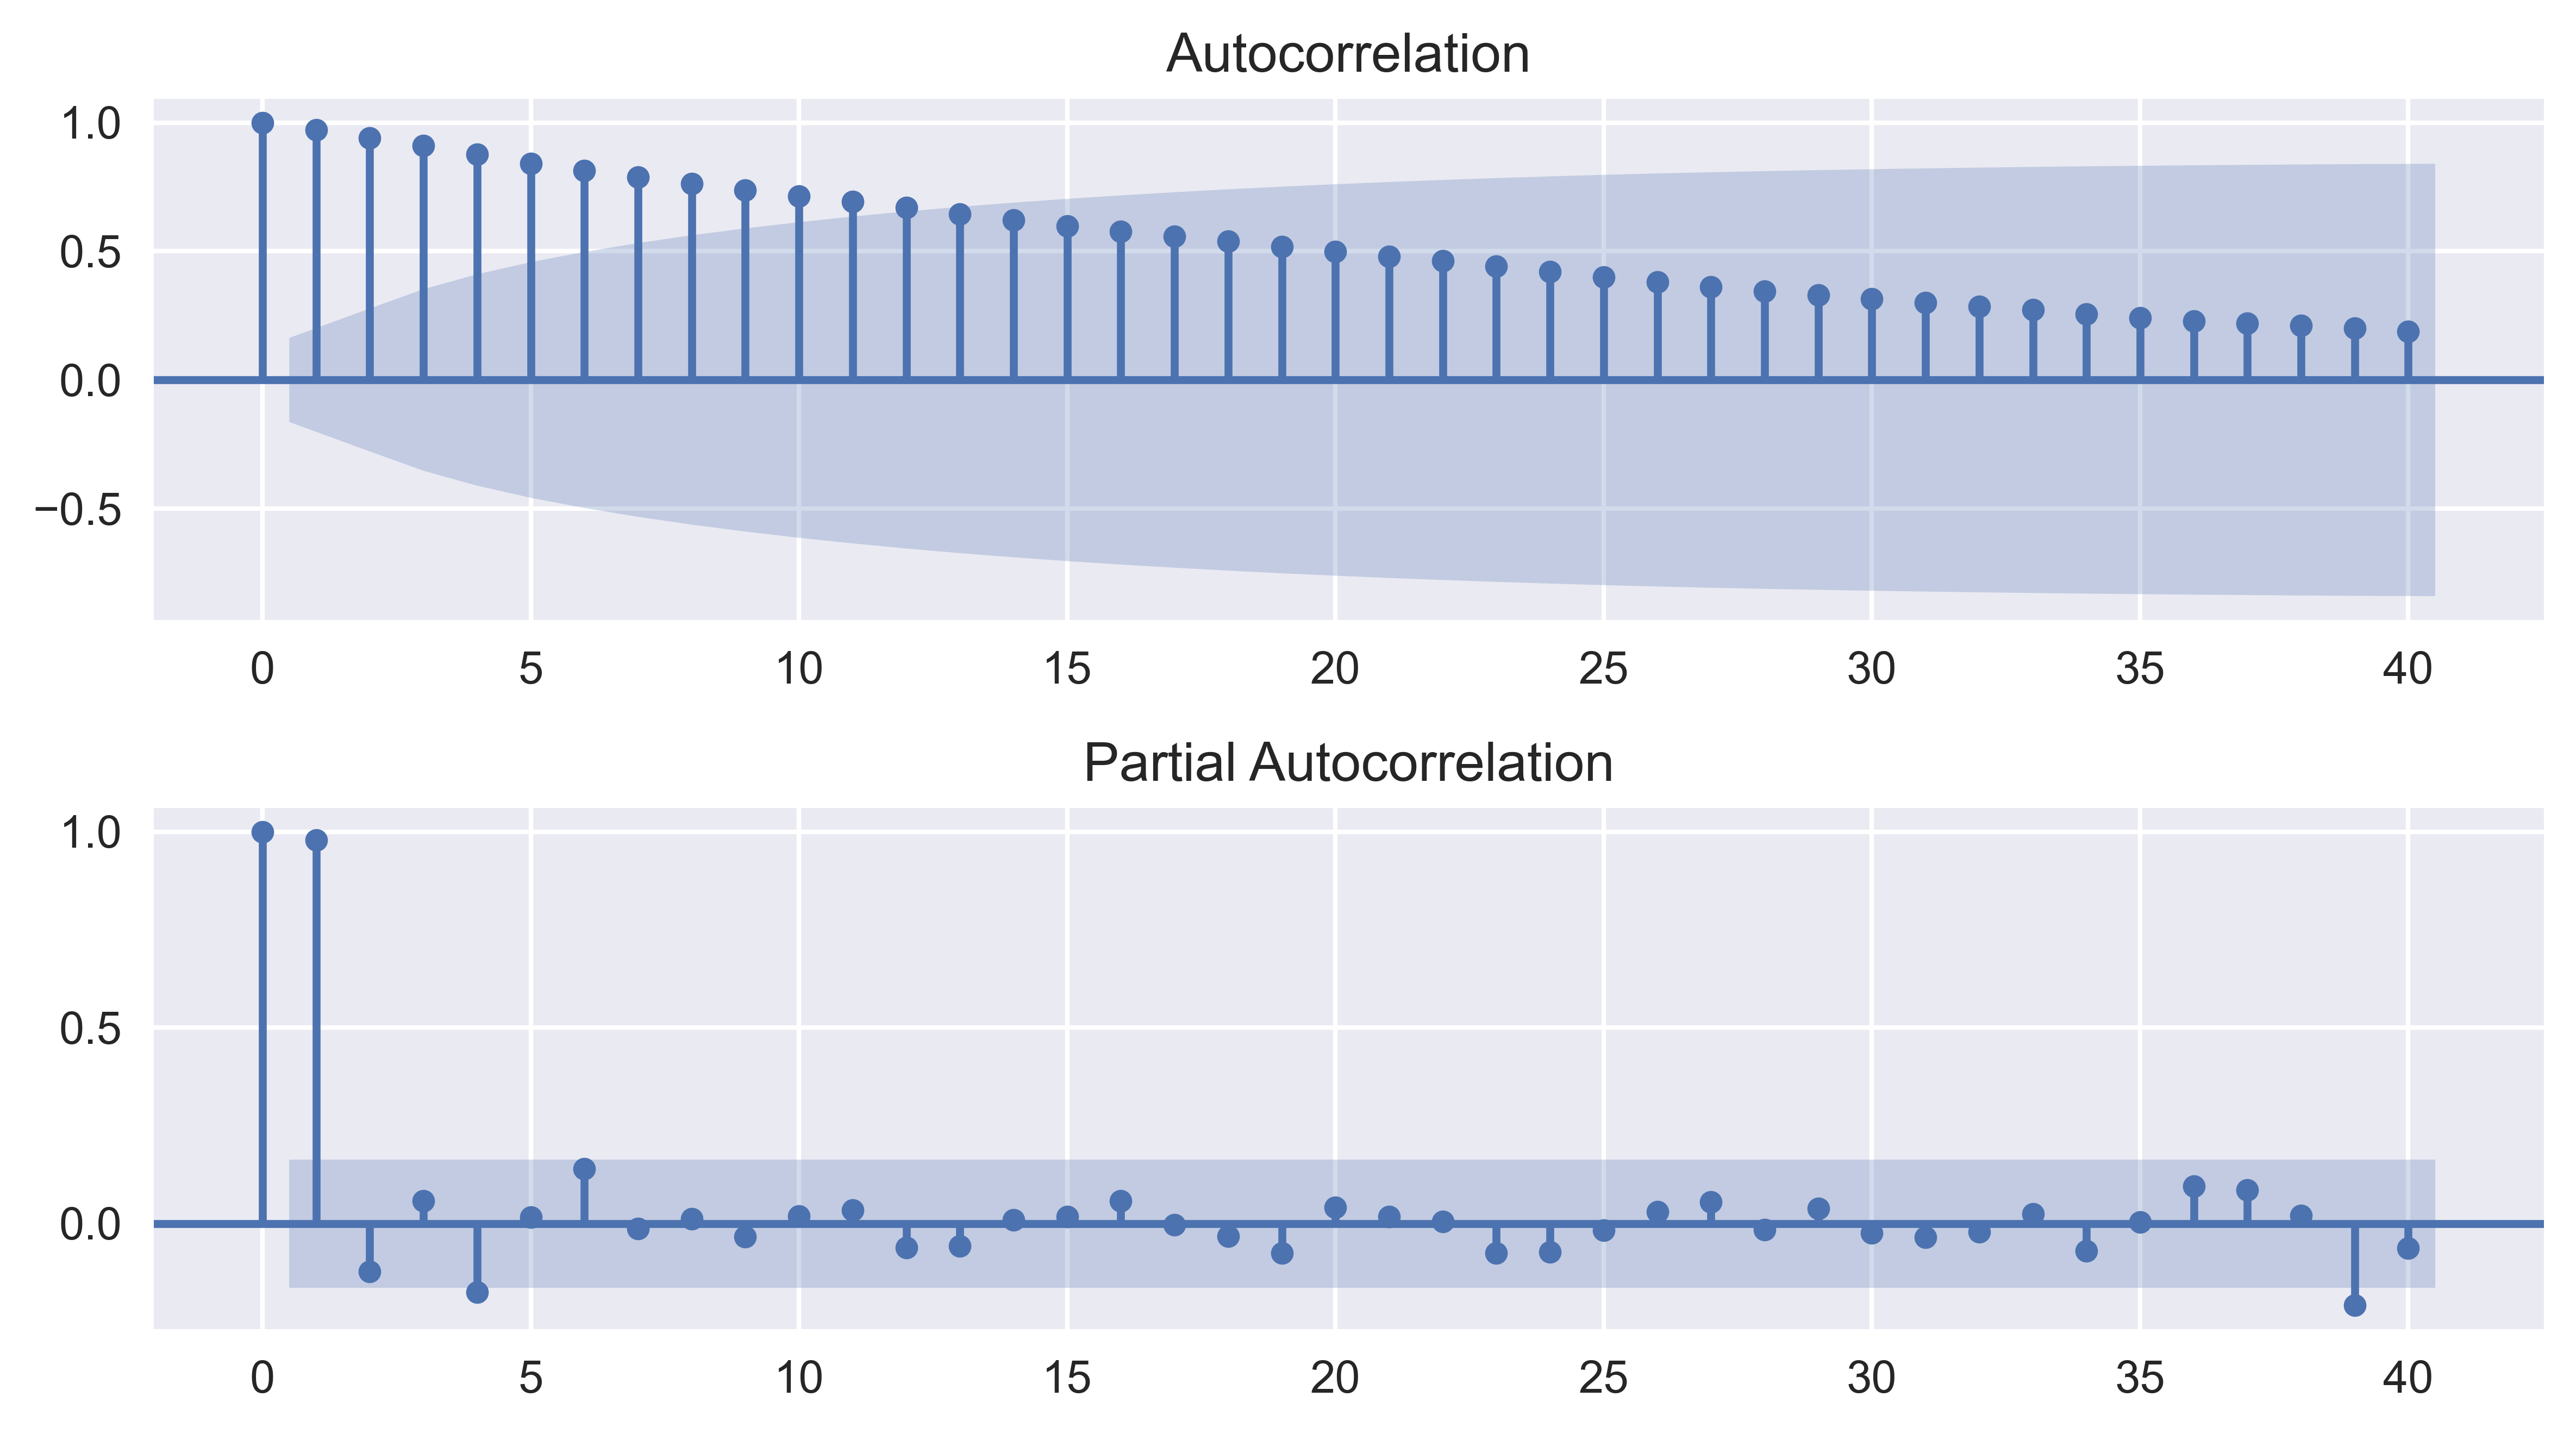

In [16]:
import matplotlib.pyplot as plt

N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(df.price, ax=ax[0], lags=N_LAGS, 
        alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df.price, ax=ax[1], lags=N_LAGS, 
         alpha=SIGNIFICANCE_LEVEL)

plt.tight_layout()
plt.show()

## Correcting for stationarity in time series

0: Download the data:

In [17]:
import quandl

QUANDL_KEY = '15L4ky9aN_bF_6uss8CA' # replace {key} with your own API key  
quandl.ApiConfig.api_key = QUANDL_KEY

df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
               start_date='2000-01-01', 
               end_date='2011-12-31')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()

In [18]:
print(f'Shape of DataFrame: {df.shape}')
df.head()

Shape of DataFrame: (144, 1)


price
Date              
2000-01-31  284.31
2000-02-29  299.86
2000-03-31  286.39
2000-04-30  279.69
2000-05-31  275.19

1. Import the libraries and update the inflation data:

In [19]:
pip install cpi

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#!pip install chapter_3_utils

In [21]:
import cpi
import pandas as pd
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
#from chapter_3_utils import test_autocorrelation

# update the CPI data (if needed)
# cpi.update()

C:\Users\cti110016\Anaconda3\lib\site-packages\cpi\__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


2. Deflate the gold prices (to 2011-12-31 USD values) and plot the results:

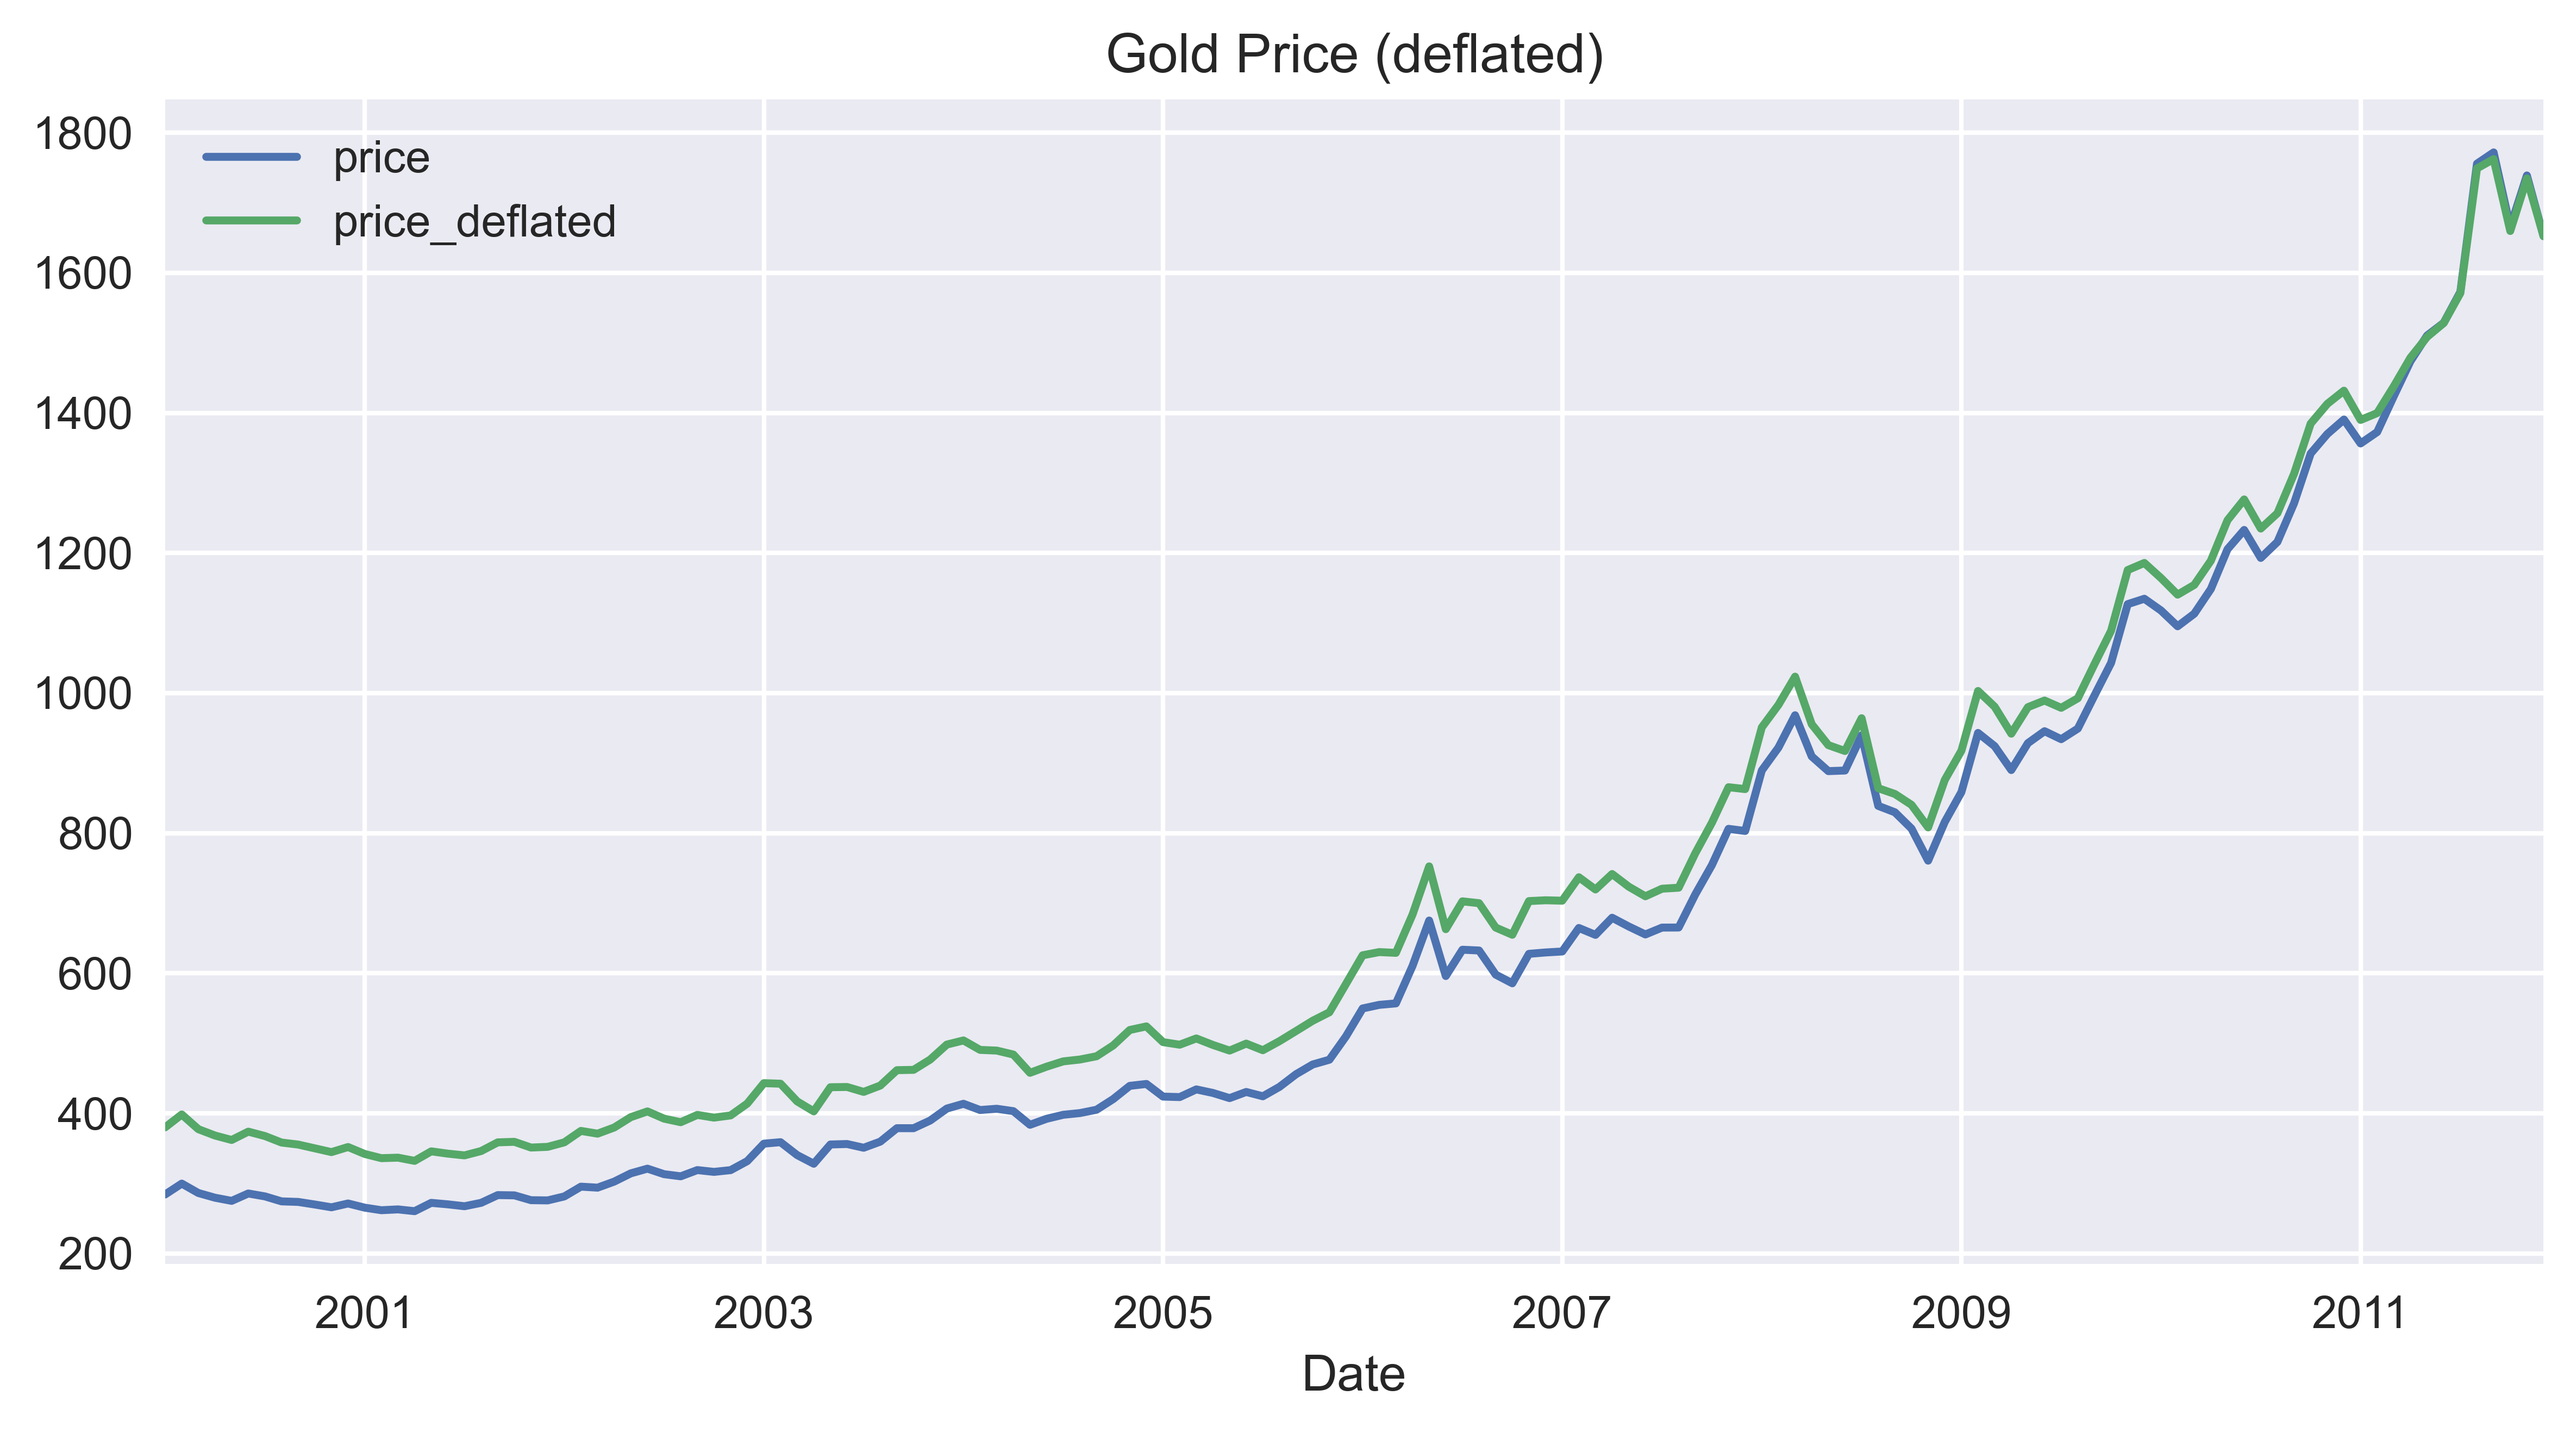

In [22]:
DEFL_DATE = date(2011, 12, 31)

df['dt_index'] = df.index.map(lambda x: x.to_pydatetime().date())
df['price_deflated'] = df.apply(lambda x: cpi.inflate(x.price,
                                                     x.dt_index, 
                                                     DEFL_DATE),
                               axis=1)
df[['price', 'price_deflated']].plot(title='Gold Price (deflated)')

plt.tight_layout()
plt.show()

3. Deflate the series using natural logarithm and plot it together with the rolling metrics:

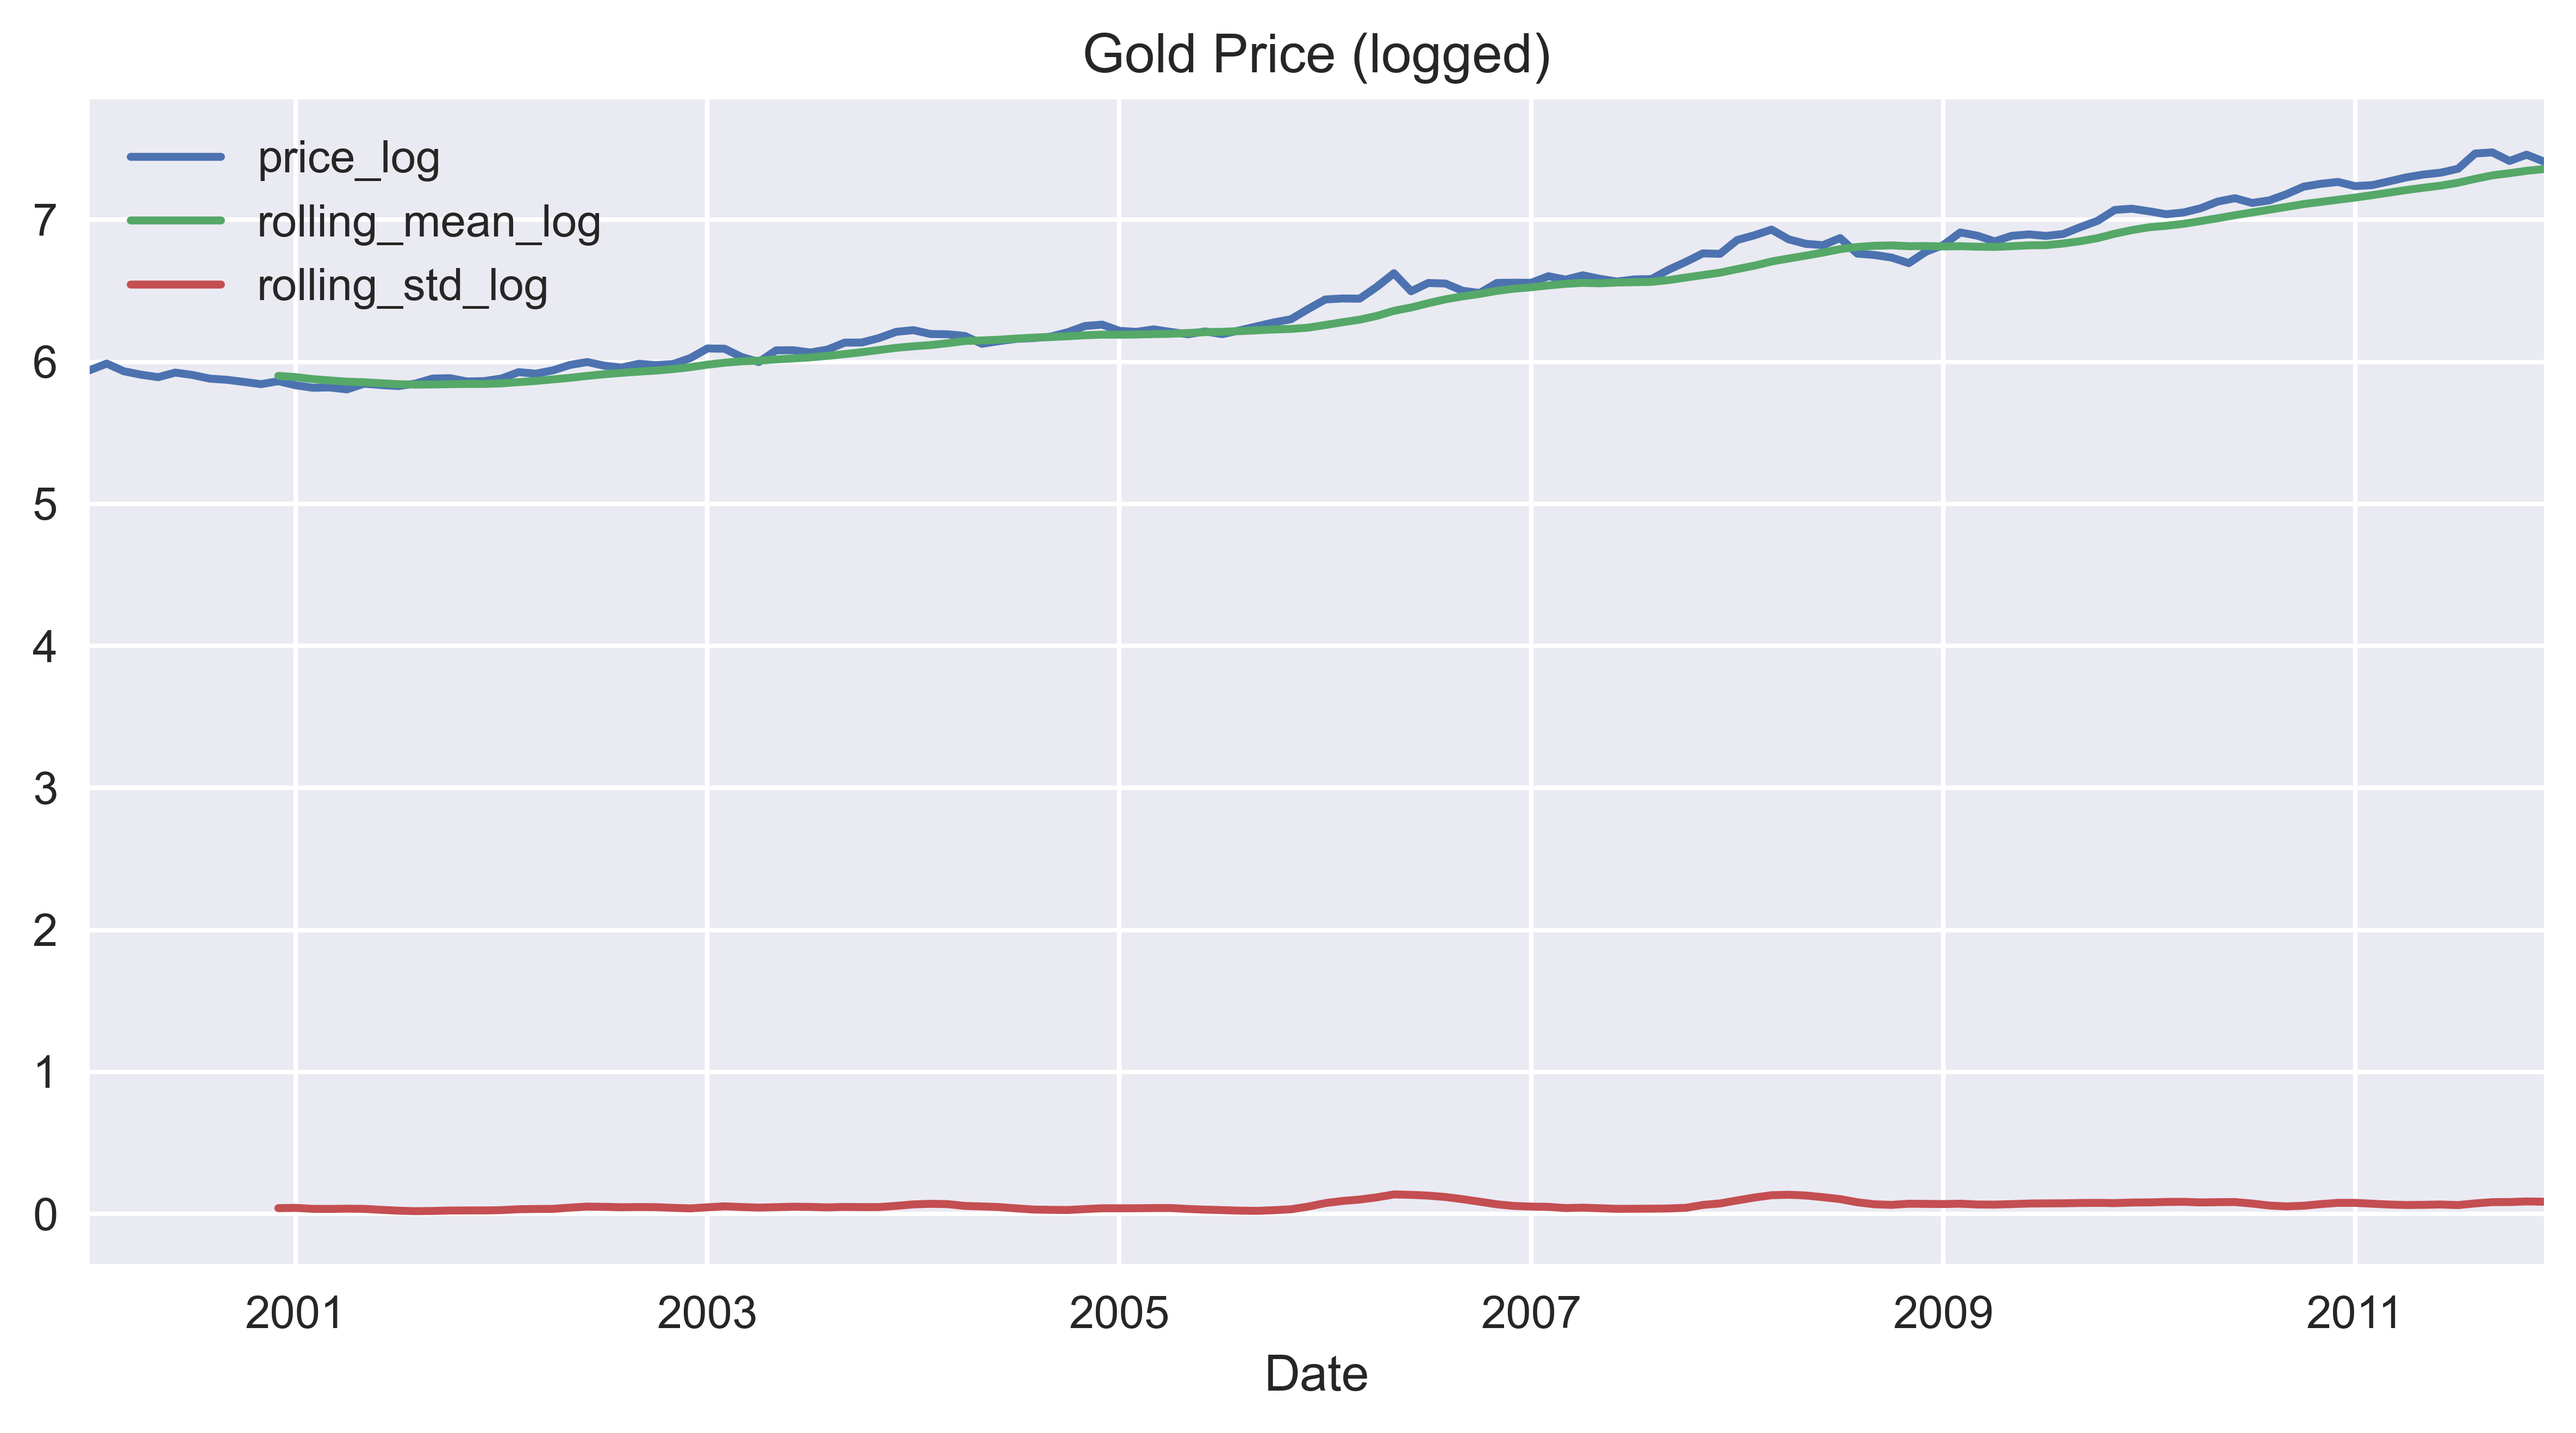

In [23]:
import numpy as np

WINDOW = 12
selected_columns = ['price_log', 'rolling_mean_log', 
                   'rolling_std_log']

df['price_log'] = np.log(df.price_deflated)
df['rolling_mean_log'] = df.price_log.rolling(WINDOW) \
    .mean()
df['rolling_std_log'] = df.price_log.rolling(WINDOW) \
    .std()

df[selected_columns].plot(title='Gold Price (logged)')

plt.tight_layout()
plt.show()

4. Use the `test_autocorrelation` (helper function for this chapter) to investigate if the series became stationary:

In [25]:
# fig = test_autocorrelation(df.price_log)

# plt.tight_layout()
# plt.show()

5. Apply differencing to the series and plot the results:

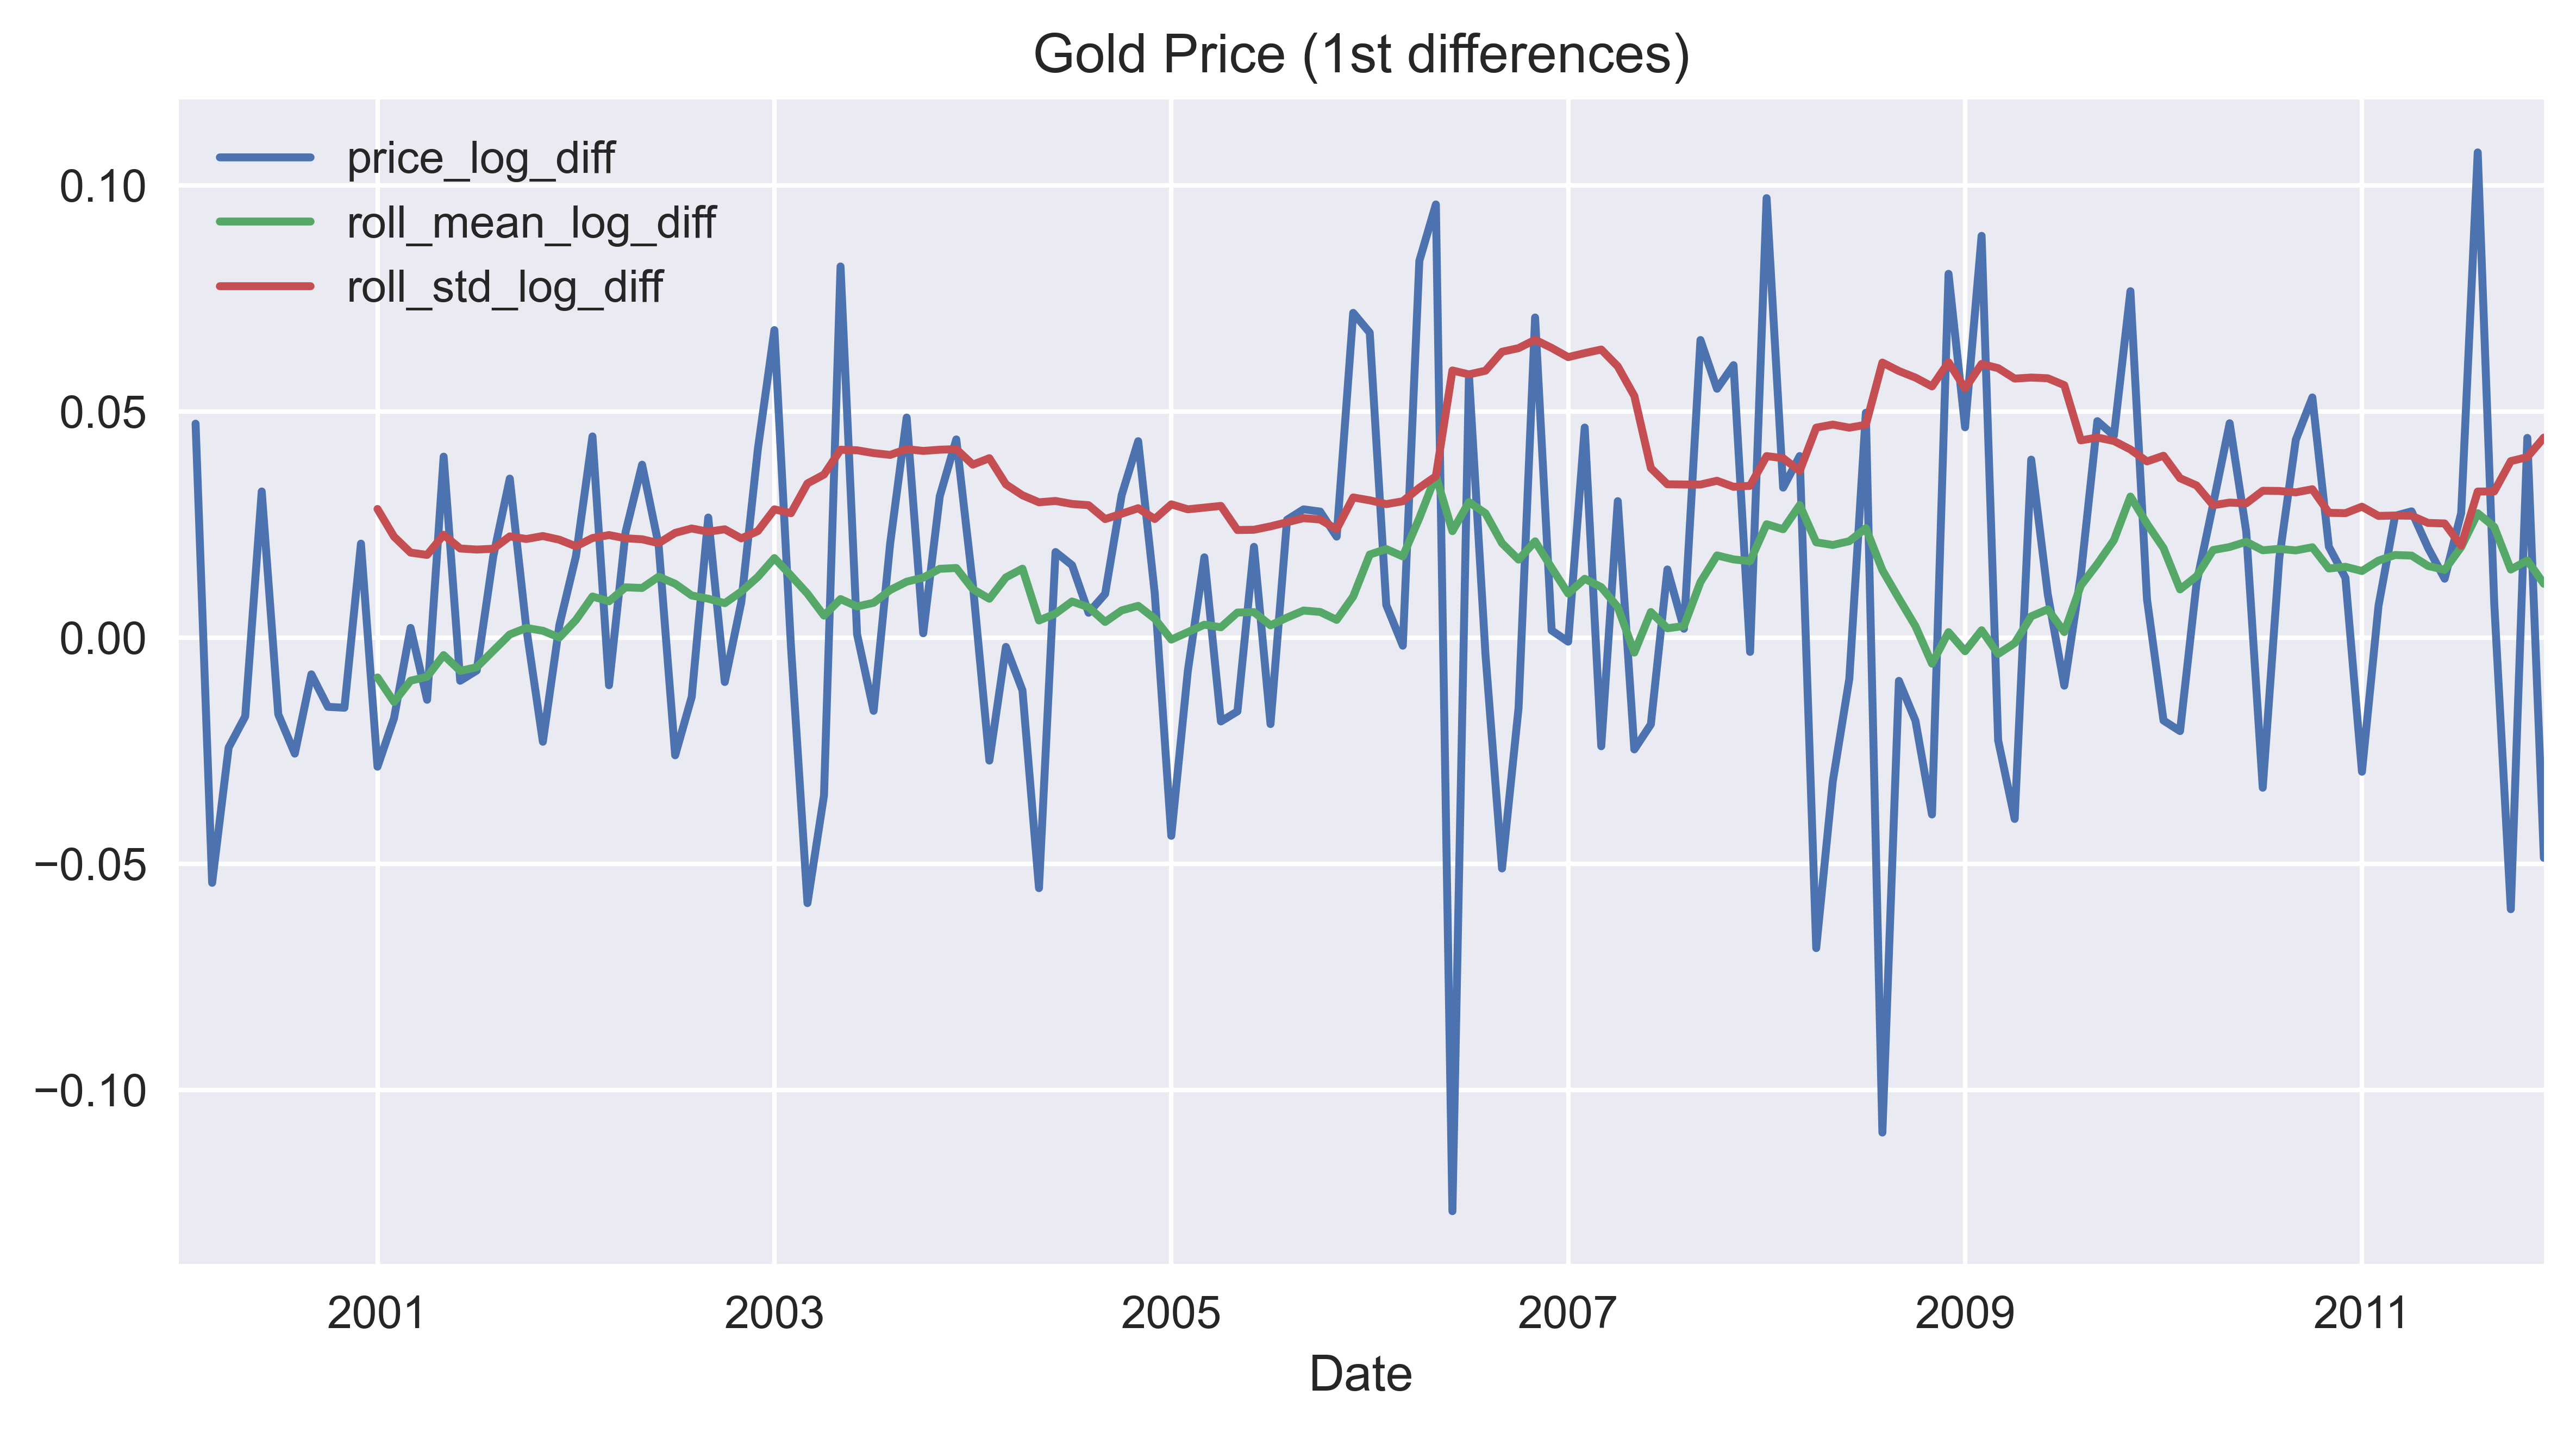

In [26]:
selected_columns = ['price_log_diff', 'roll_mean_log_diff', 
                   'roll_std_log_diff']

df['price_log_diff'] = df.price_log.diff(1)
df['roll_mean_log_diff'] = df.price_log_diff.rolling(WINDOW) \
    .mean()
df['roll_std_log_diff'] = df.price_log_diff.rolling(WINDOW) \
    .std()
df[selected_columns].plot(title='Gold Price (1st differences)')

plt.tight_layout()
plt.show()

6. Test if the series became stationary:

In [27]:
# fig = test_autocorrelation(df.price_log_diff.dropna())

# plt.tight_layout()
# plt.show()

NameError: name 'test_autocorrelation' is not defined

## Modeling time series with exponential smoothing methods

In [29]:
import seaborn as sns 

plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')

COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]

<Figure size 2400x1350 with 0 Axes>

1. Import the libraries:

In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, 
                                        SimpleExpSmoothing, 
                                        Holt)

2. Download the adjusted stock prices of Google:

In [31]:
df = yf.download('GOOG',
                start='2010-01-01',
                end='2018-12-31',
                adjusted=True,
                progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 2264 rows of data.


3. Aggregate to monthly frequency:

In [32]:
goog = df.resample('M') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close 

4. Create the training/test split:

In [33]:
train_indices = goog.index.year < 2018
goog_train = goog[train_indices]
goog_test = goog[~train_indices]

test_length = len(goog_test)

5. Plot the prices:

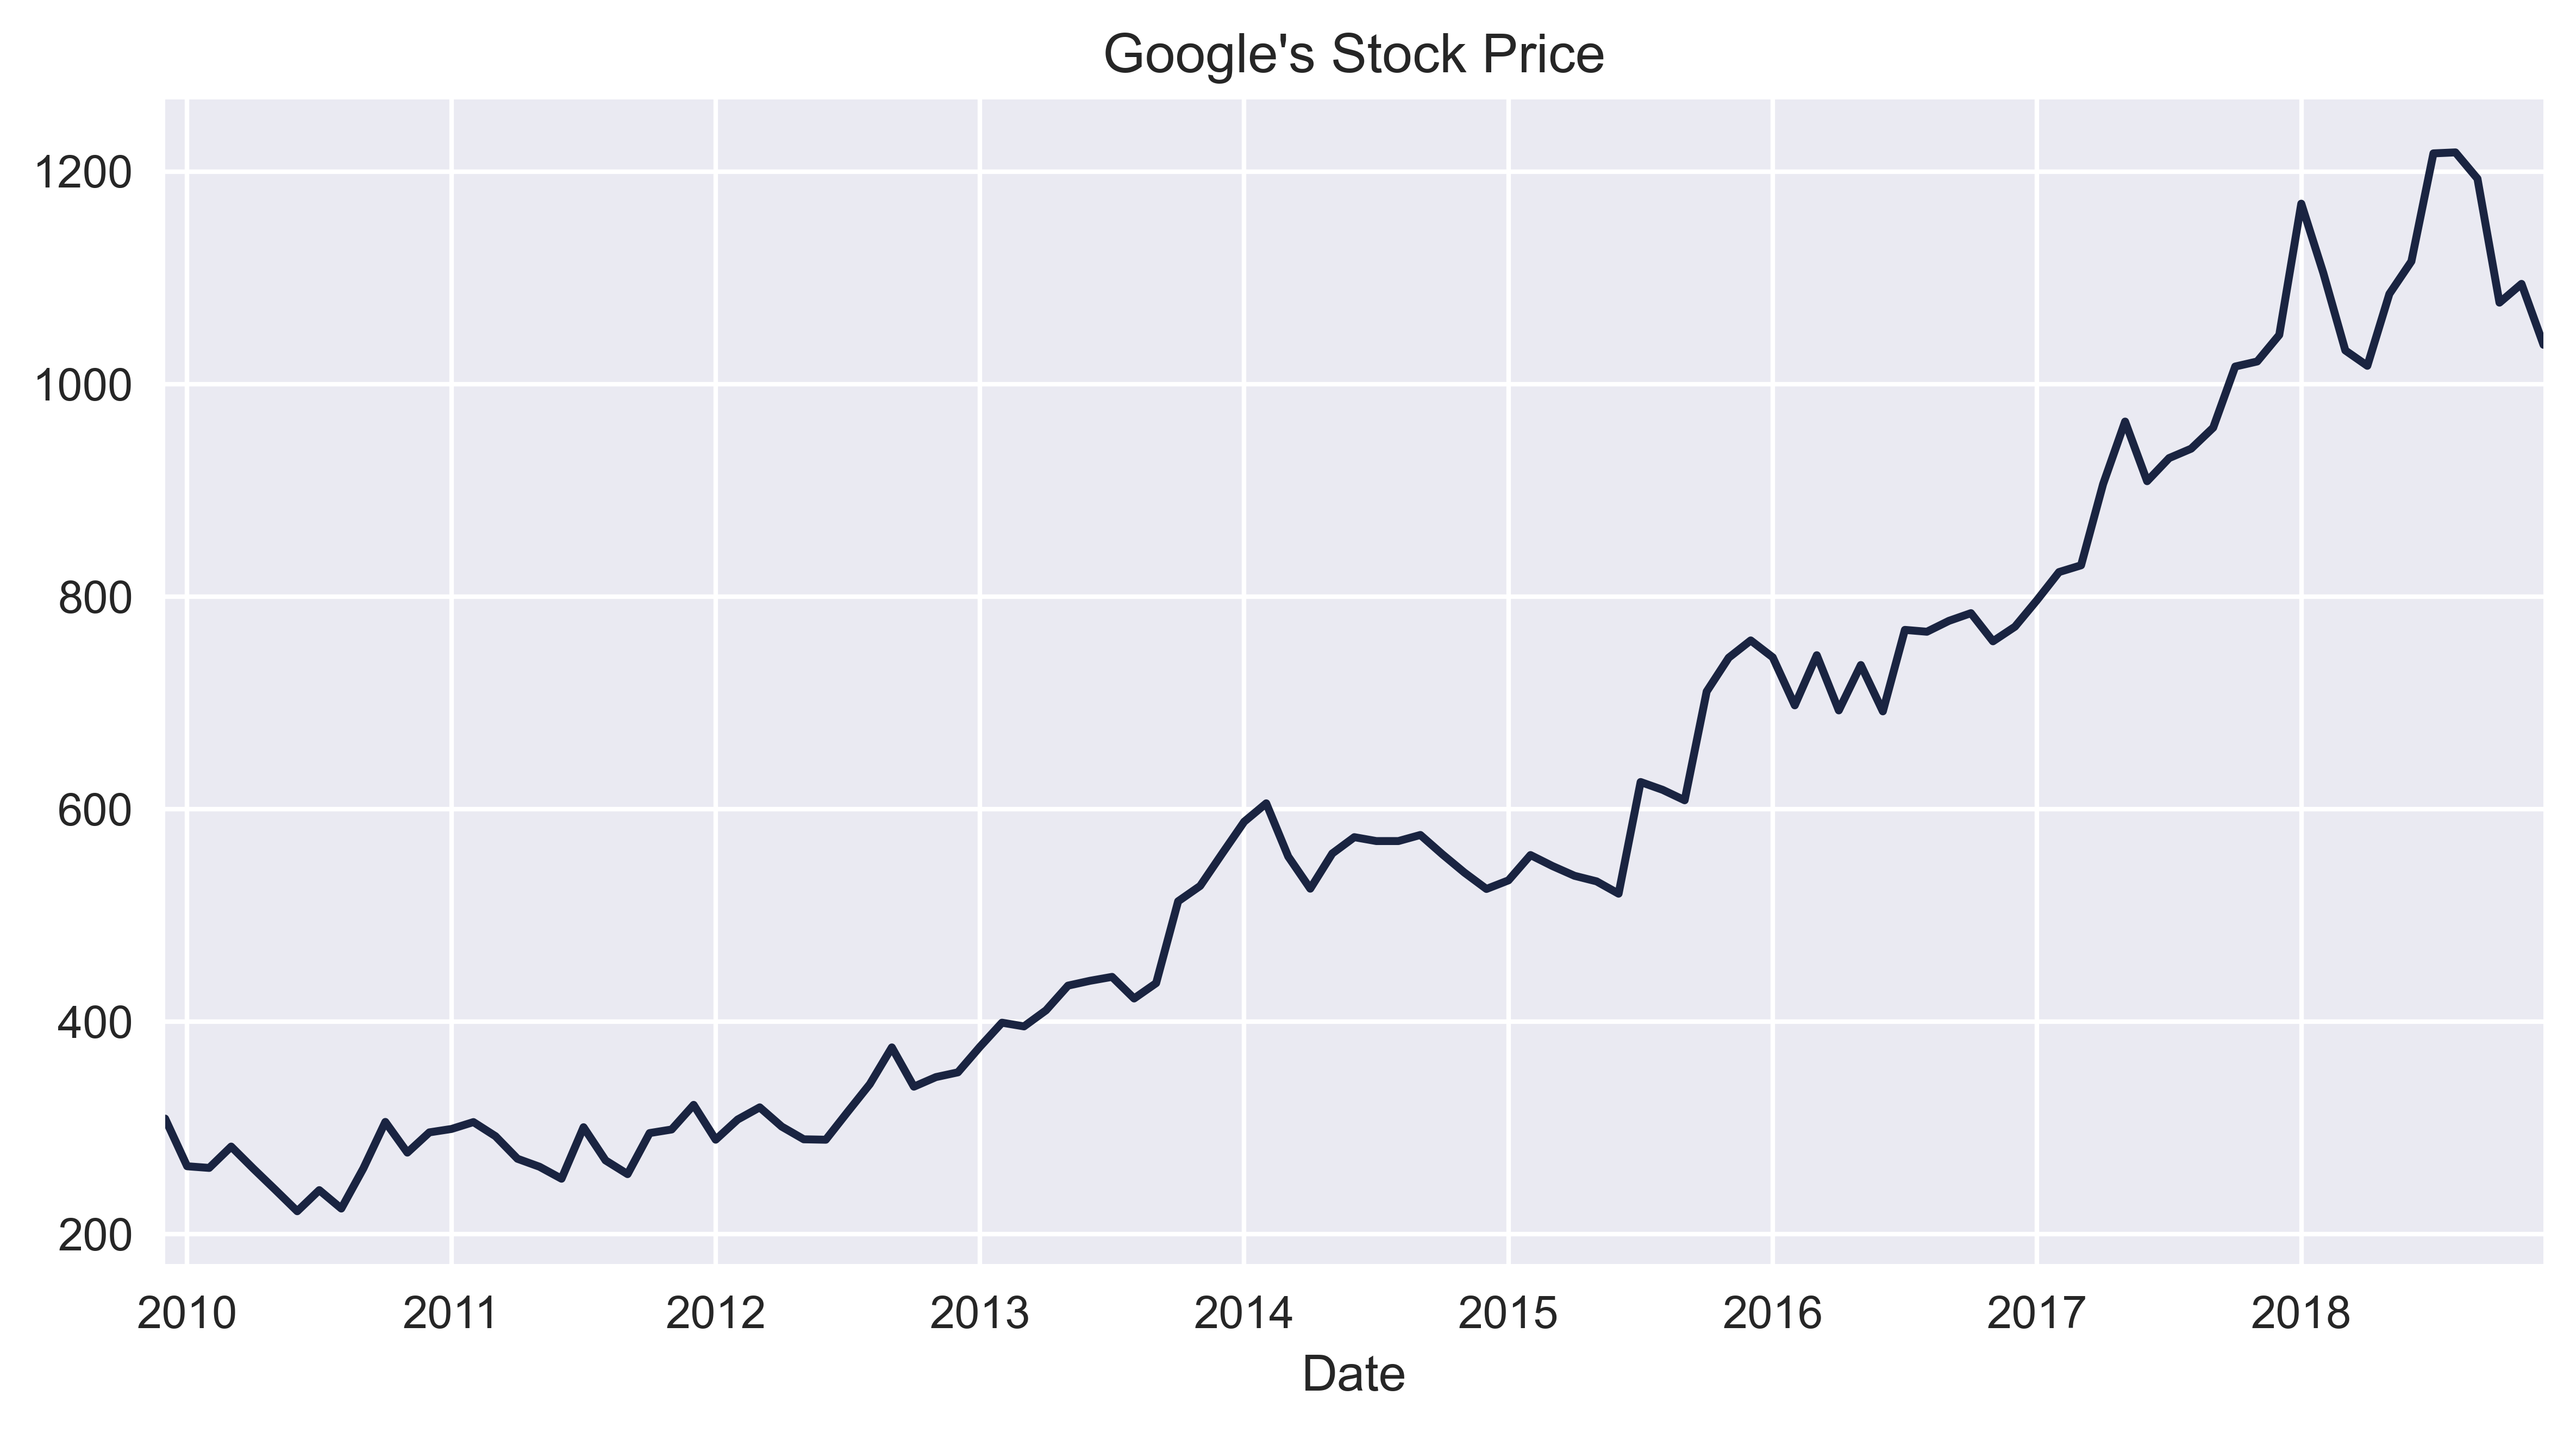

In [34]:
goog.plot(title="Google's Stock Price")

plt.tight_layout()
plt.show()

6. Fit 3 Simple Exponential Smoothing models and create forecasts:

In [35]:
ses_1 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.2)
ses_forecast_1 = ses_1.forecast(test_length)

ses_2 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.5)
ses_forecast_2 = ses_2.forecast(test_length)

ses_3 = SimpleExpSmoothing(goog_train).fit()
alpha = ses_3.model.params['smoothing_level']
ses_forecast_3 = ses_3.forecast(test_length)

7. Plot the original prices together with the models' results:

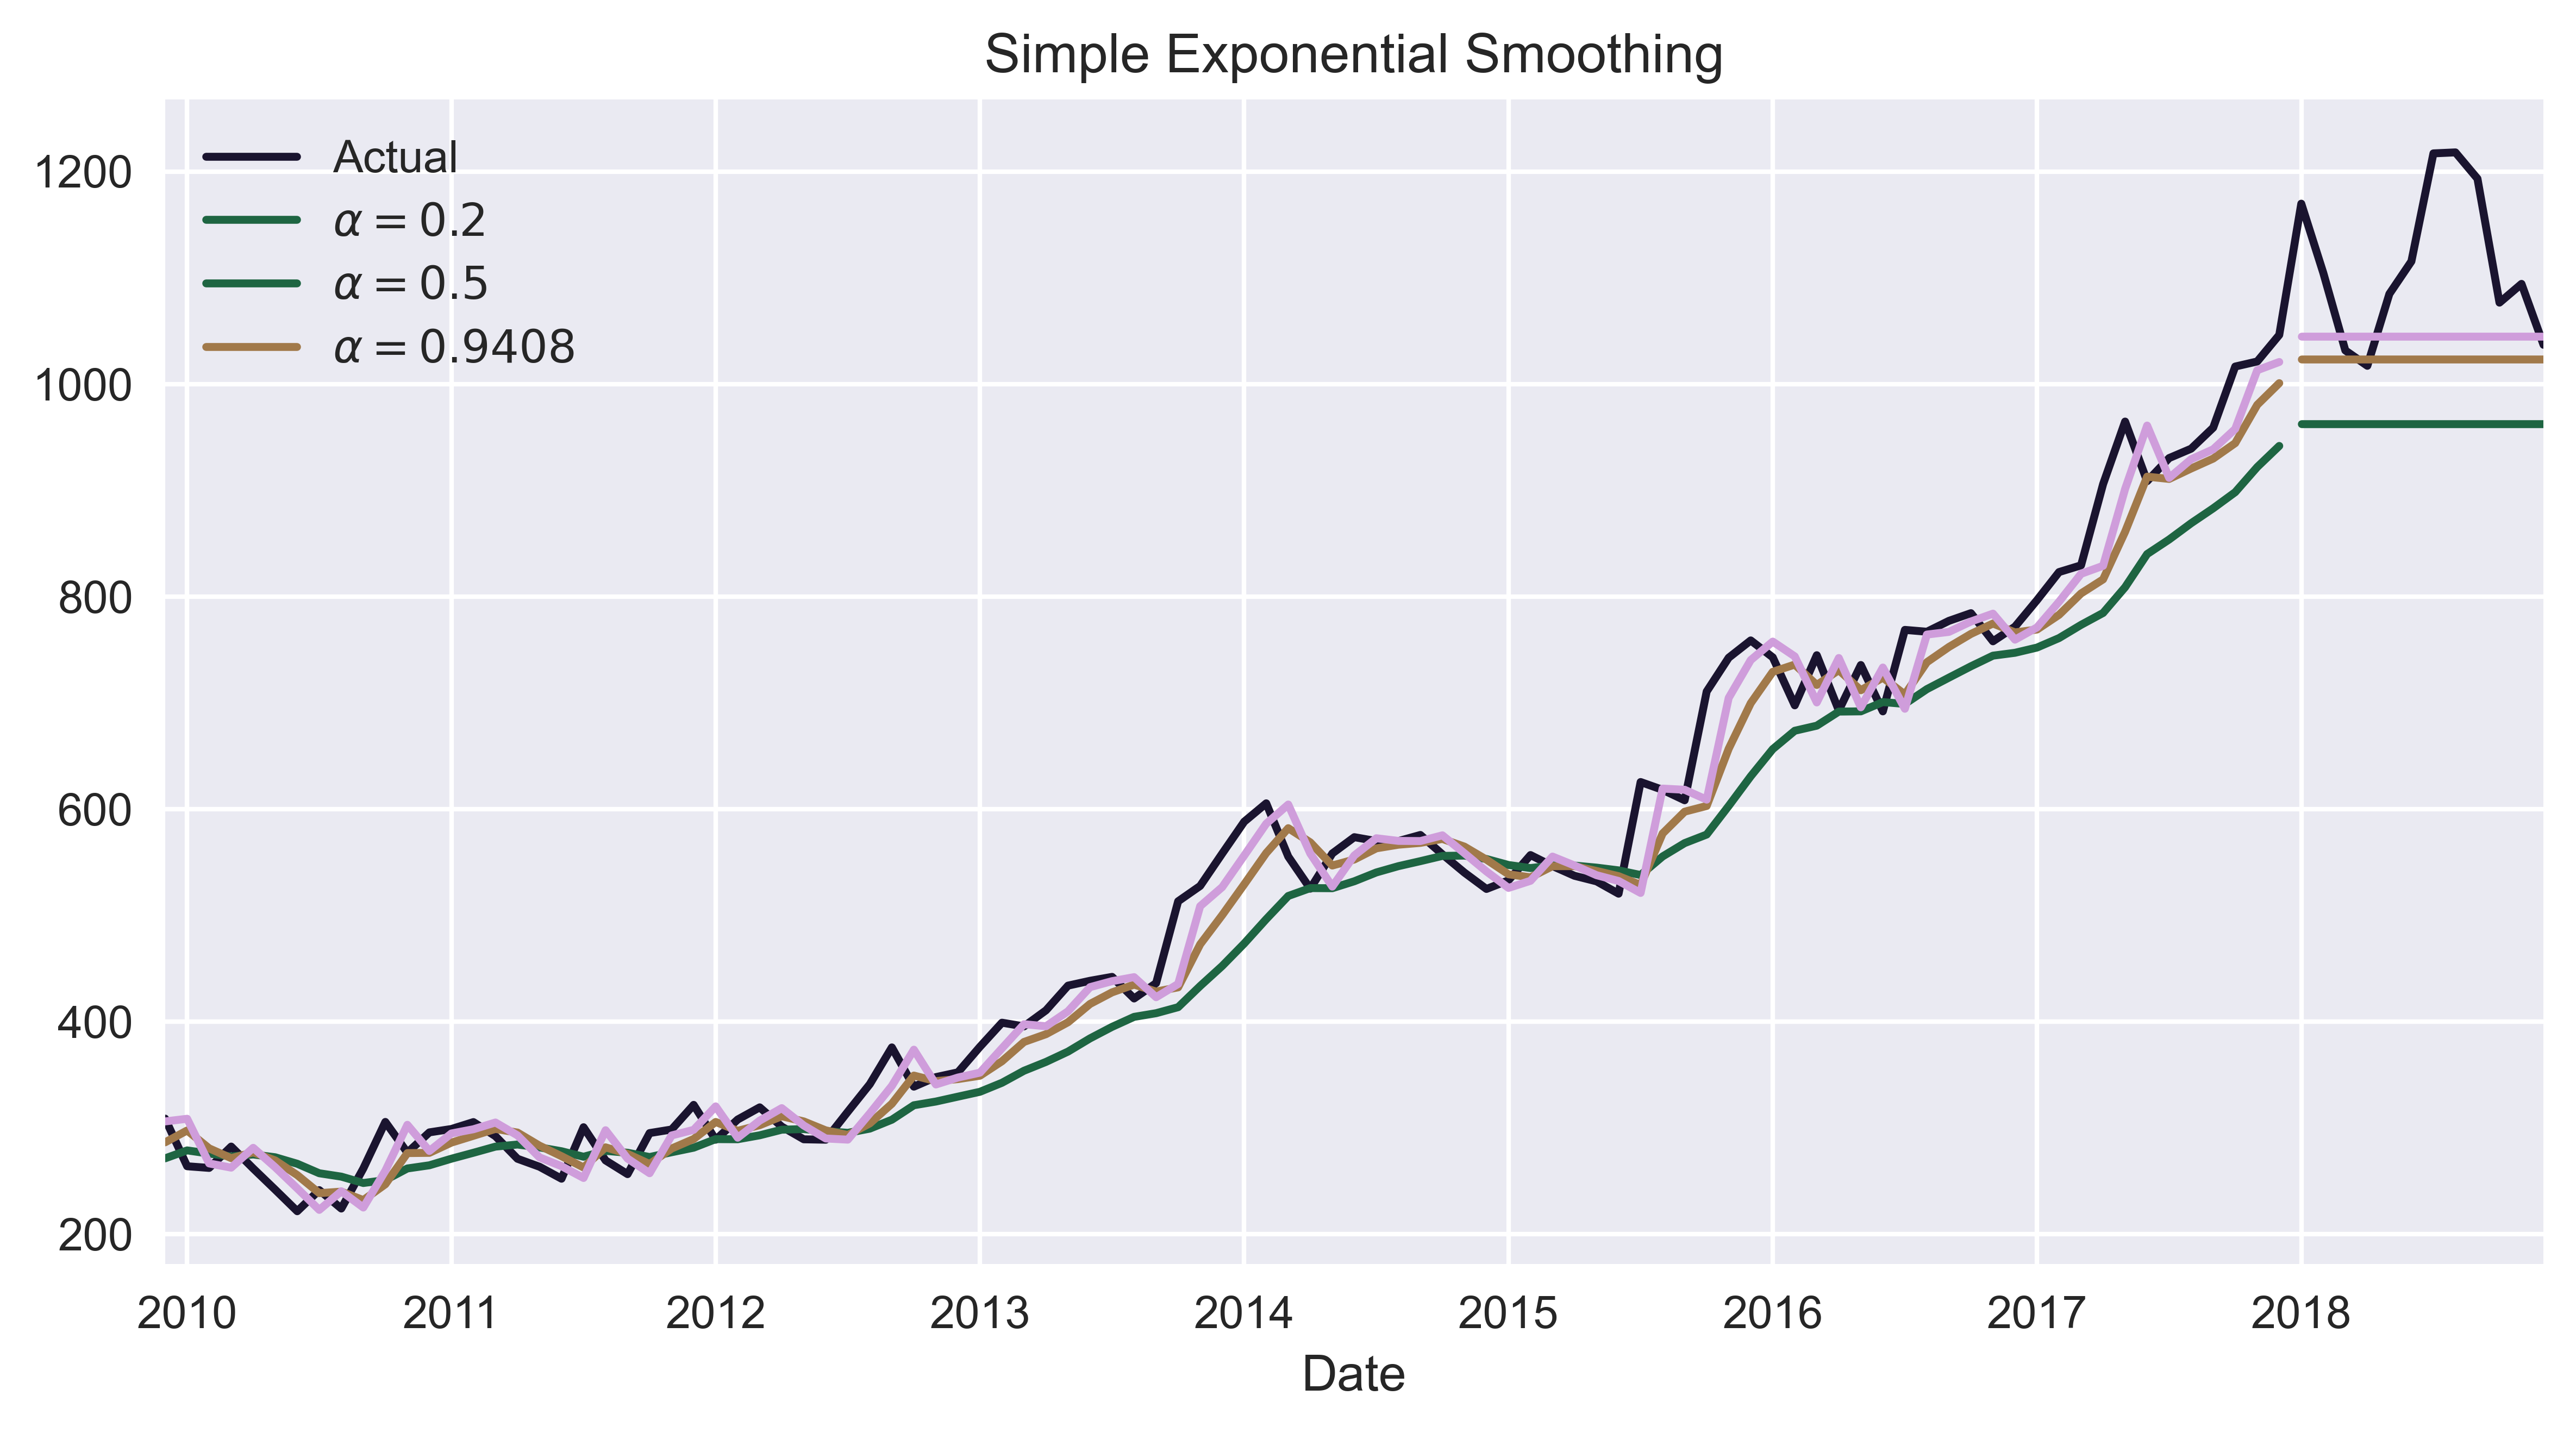

In [36]:
goog.plot(color=COLORS[0], 
         title='Simple Exponential Smoothing',
         label='Actual',
         legend=True)

ses_forecast_1.plot(color=COLORS[1], legend=True, 
                   label=r'$\alpha=0.2$')
ses_1.fittedvalues.plot(color=COLORS[1])

ses_forecast_2.plot(color=COLORS[2], legend=True, 
                   label=r'$\alpha=0.5$')
ses_2.fittedvalues.plot(color=COLORS[2])

ses_forecast_3.plot(color=COLORS[3], legend=True, 
                   label=r'$\alpha={0:.4f}$'.format(alpha))
ses_3.fittedvalues.plot(color=COLORS[3])

plt.tight_layout()
plt.show()

8. Fit 3 variants of the Holt's Smoothing models and create forecasts:

In [37]:
# Holt's model with linear trend
hs_1 = Holt(goog_train).fit()
hs_forecast_1 = hs_1.forecast(test_length)

# Holt's model with exponential trend
hs_2 = Holt(goog_train, exponential=True).fit()
# equivalent to ExponentialSmoothing(goog_train, trend='mul').fit()
hs_forecast_2 = hs_2.forecast(test_length)

# Holt's model with exponential trend and damping
hs_3 = Holt(goog_train, exponential=False, 
           damped=True).fit(damping_slope=0.99)
hs_forecast_3 = hs_3.forecast(test_length)

9. Plot the original prices together with the models' results:

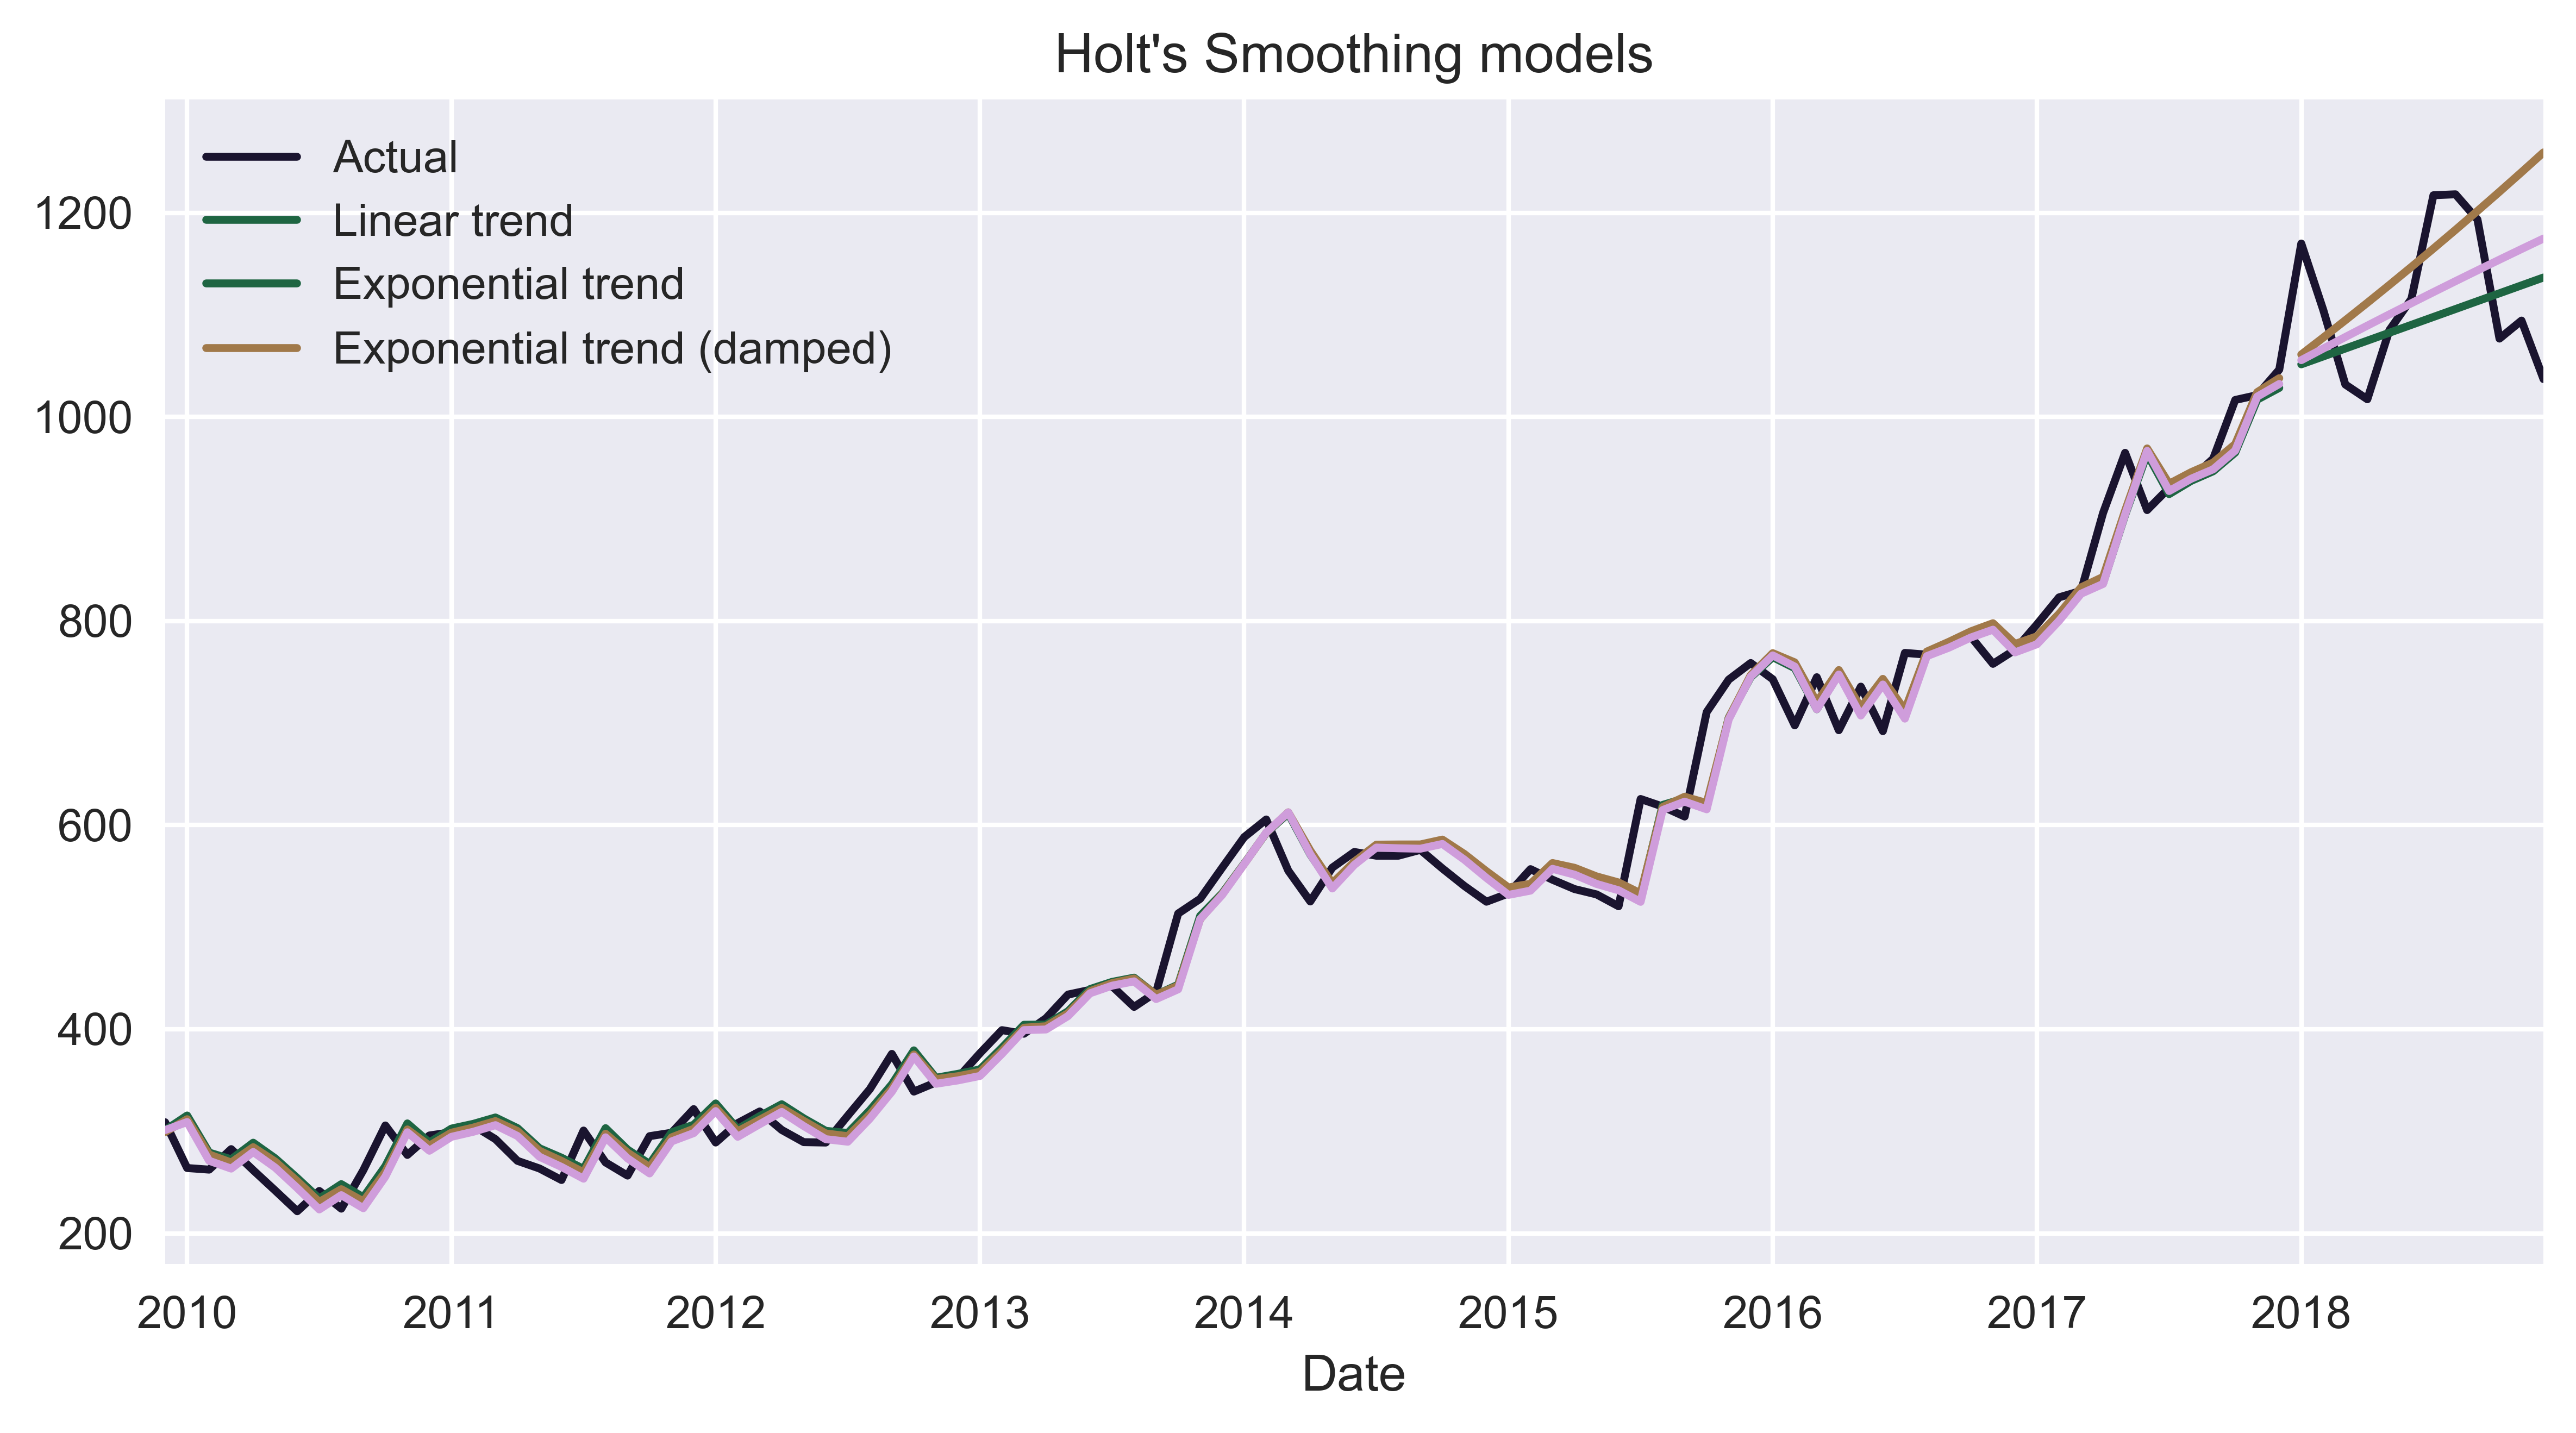

In [38]:
goog.plot(color=COLORS[0],
         title="Holt's Smoothing models",
         label='Actual',
         legend=True)

hs_1.fittedvalues.plot(color=COLORS[1])
hs_forecast_1.plot(color=COLORS[1], legend=True, 
                  label='Linear trend')

hs_2.fittedvalues.plot(color=COLORS[2])
hs_forecast_2.plot(color=COLORS[2], legend=True, 
                  label='Exponential trend')

hs_3.fittedvalues.plot(color=COLORS[3])
hs_forecast_3.plot(color=COLORS[3], legend=True, 
                  label='Exponential trend (damped)')

plt.tight_layout()
plt.show()

## Modeling time series with ARIMA class models

1. Import the libraries:

In [41]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
#from chapter_3_utils import test_autocorrelation

2. Download Google's stock prices and resample to weekly frequency:

In [42]:
df = yf.download('GOOG',
                start='2015-01-01',
                end='2018-12-31',
                adjusted=True,
                progress=False)

goog = df.resample('W') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close

3. Apply the first differences to the price series and plot them together:

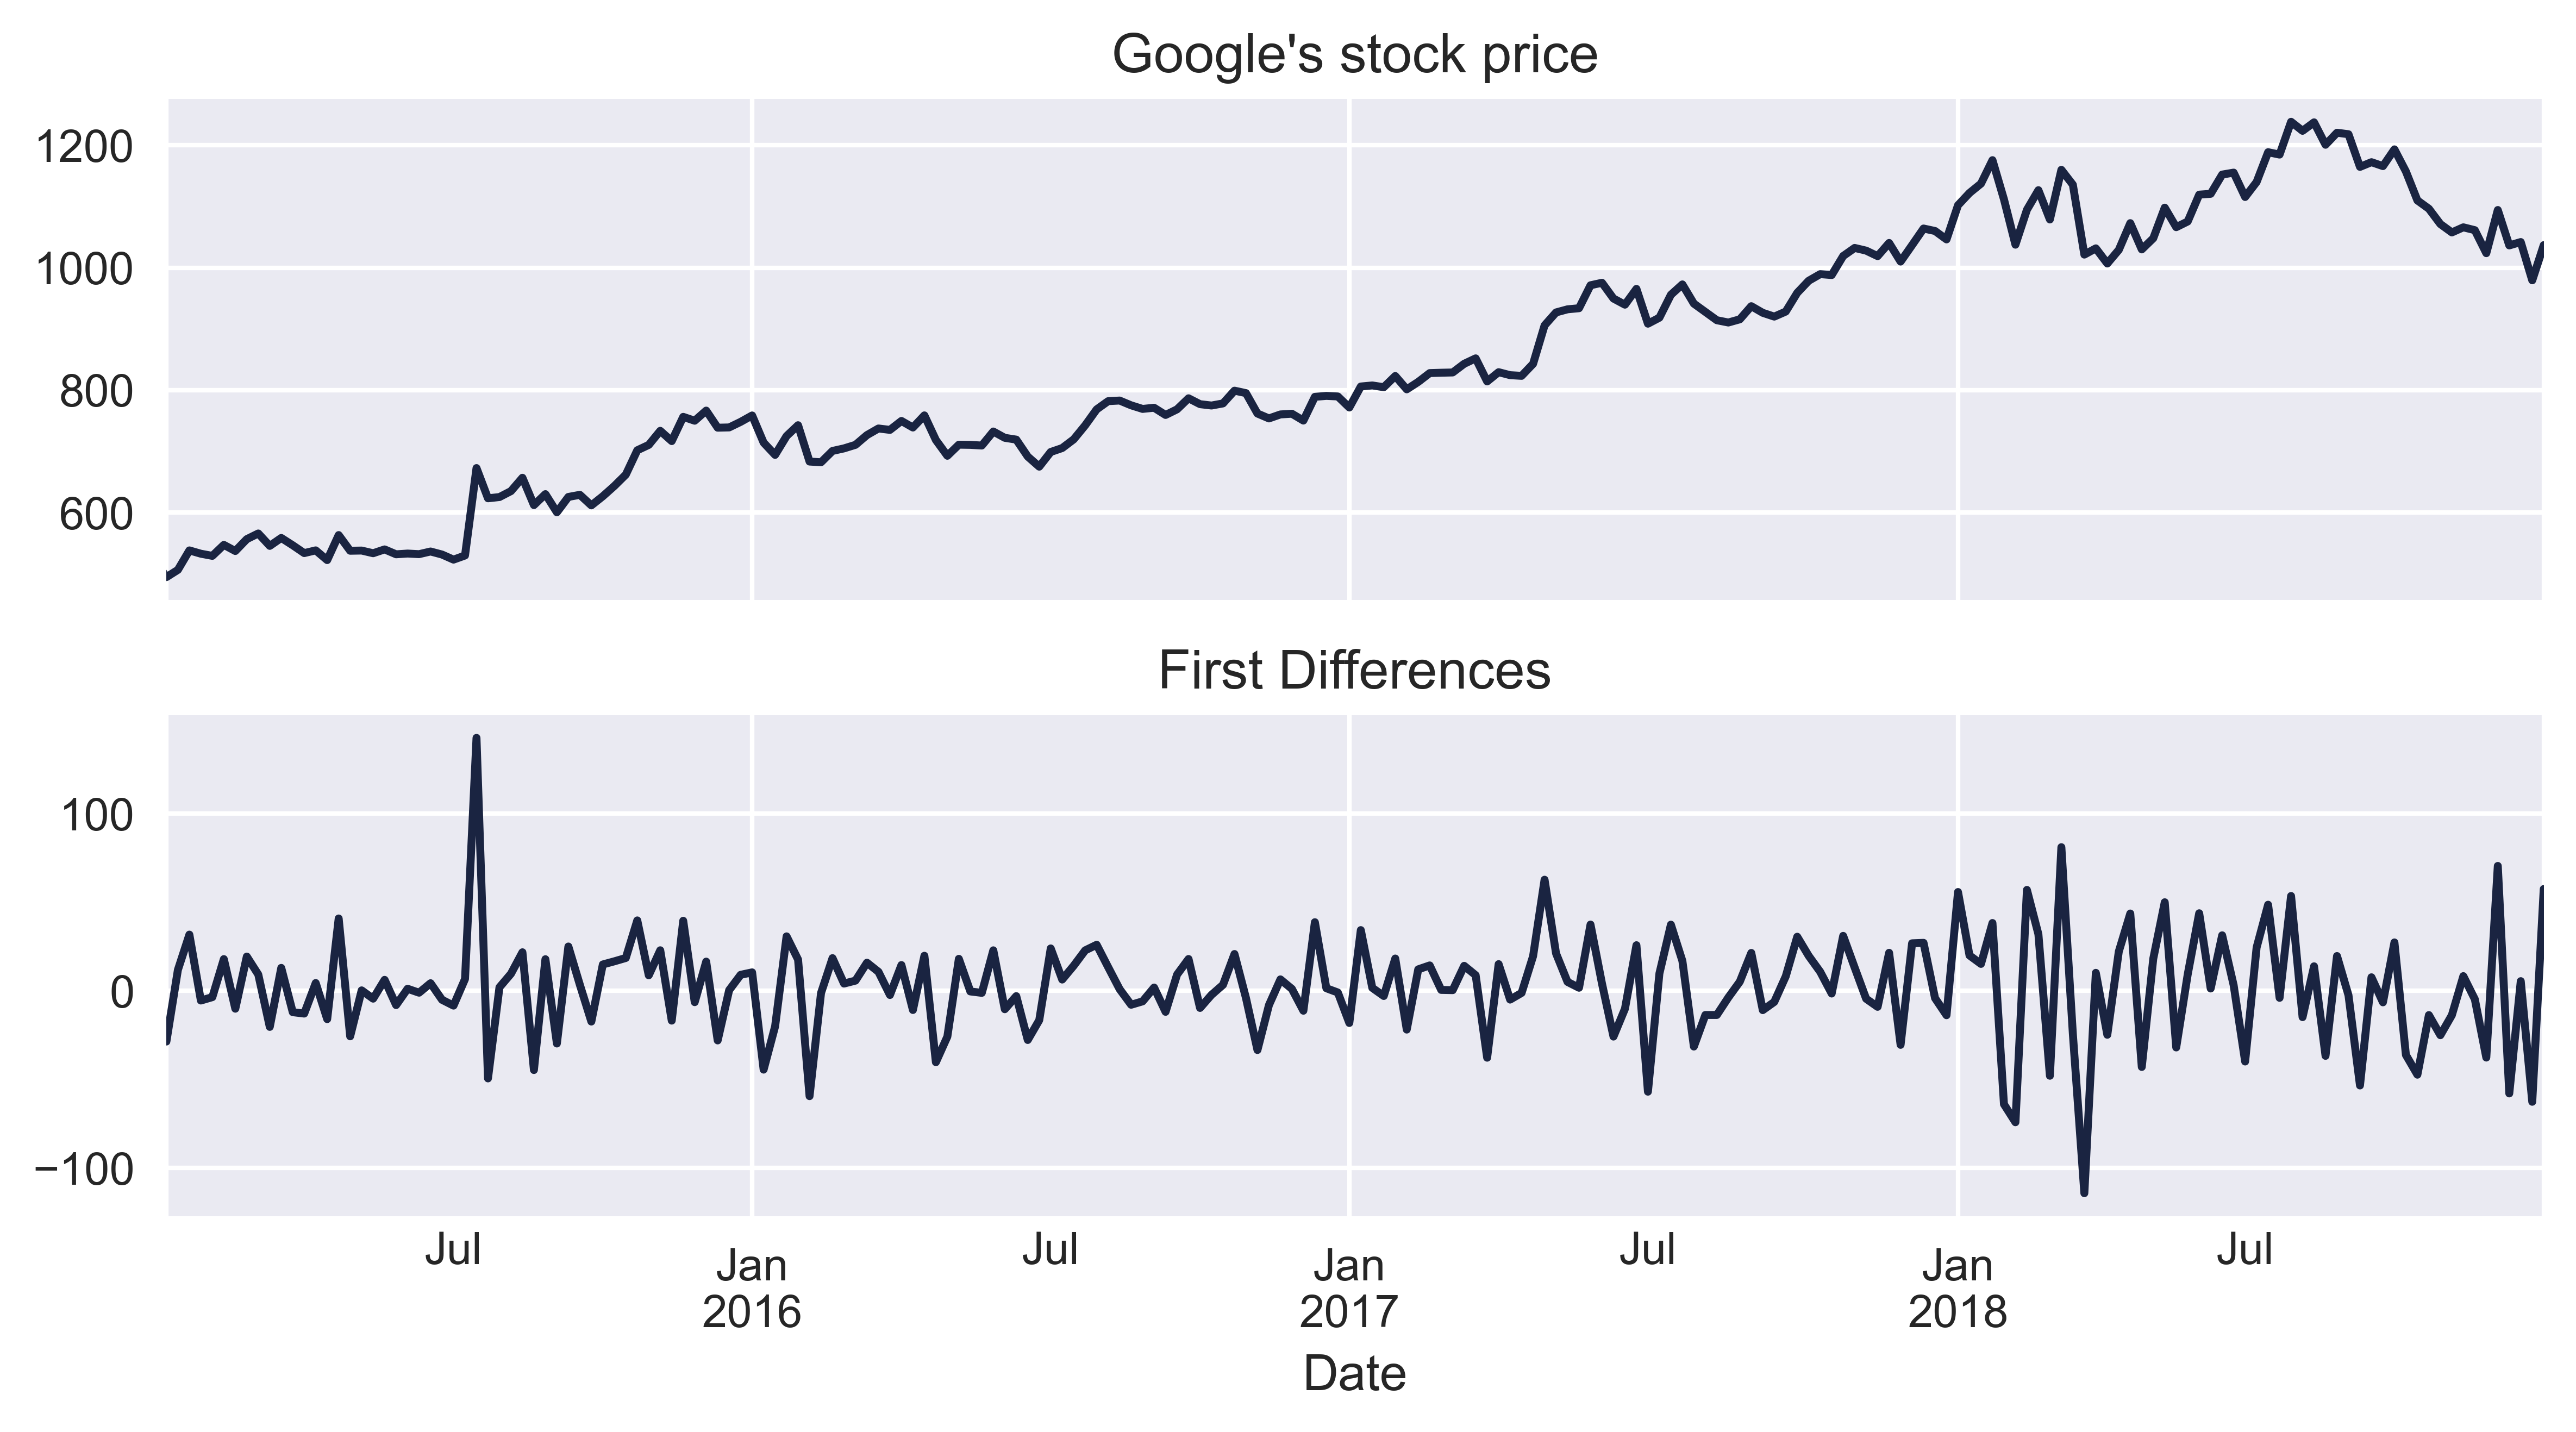

In [43]:
goog_diff = goog.diff().dropna()

fig, ax = plt.subplots(2, sharex=True)
goog.plot(title = "Google's stock price", ax=ax[0])
goog_diff.plot(ax=ax[1], title='First Differences')

plt.tight_layout()
plt.show()

4. Test the differenced series for stationarity:

In [48]:
# fig = test_autocorrelation(goog_diff)

# plt.tight_layout()
# plt.show()

5. Based on the results of the tests, specify the ARIMA model and fit it to the data:

In [49]:
arima = ARIMA(goog, order=(2, 1, 1)).fit(disp=0)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                  208
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -987.233
Method:                       css-mle   S.D. of innovations             27.859
Date:                Thu, 16 Dec 2021   AIC                           1984.466
Time:                        12:08:33   BIC                           2001.154
Sample:                    01-11-2015   HQIC                          1991.214
                         - 12-30-2018                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.4700      1.441      1.714      0.087      -0.354       5.294
ar.L1.D.adj_close    -0.3908      0.280     -1.398      0.162      -0.939       0.157
ar.L2.D.adj_close    -0.1910      0.082     -2.322      0.020      -0.352      -0.030
ma.L1.D.adj_close     0.1780      0.280      0.637      0.524      -0.370       0.726
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0232           -2.0467j            2.2883           -0.3238
AR.2           -1.0232           +2.0467j            2.2883            0.3238
MA.1           -5.6166           +0.0000j            5.6166            0.5000
-----------------------------------------------------------------------------
"""

In [50]:
def arima_diagnostics(resids, n_lags=40):
    '''
    Function for diagnosing the fit of an ARIMA model by investigating the residuals.
    
     Parameters
     ----------
     resids : np.array
     An array containing the residuals of a fitted model
     
     n_lags : int
     Number of lags for autocorrelation plot
     
     Returns
     -------
     fig : matplotlib.figure.Figure
     Created figure
     '''''
    
    # create placeholder subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # residuals over time
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')
    
    # distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
    
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')
    
    # ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')
    
    return fig

7. Test the residuals of the fitted ARIMA model:

C:\Users\cti110016\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


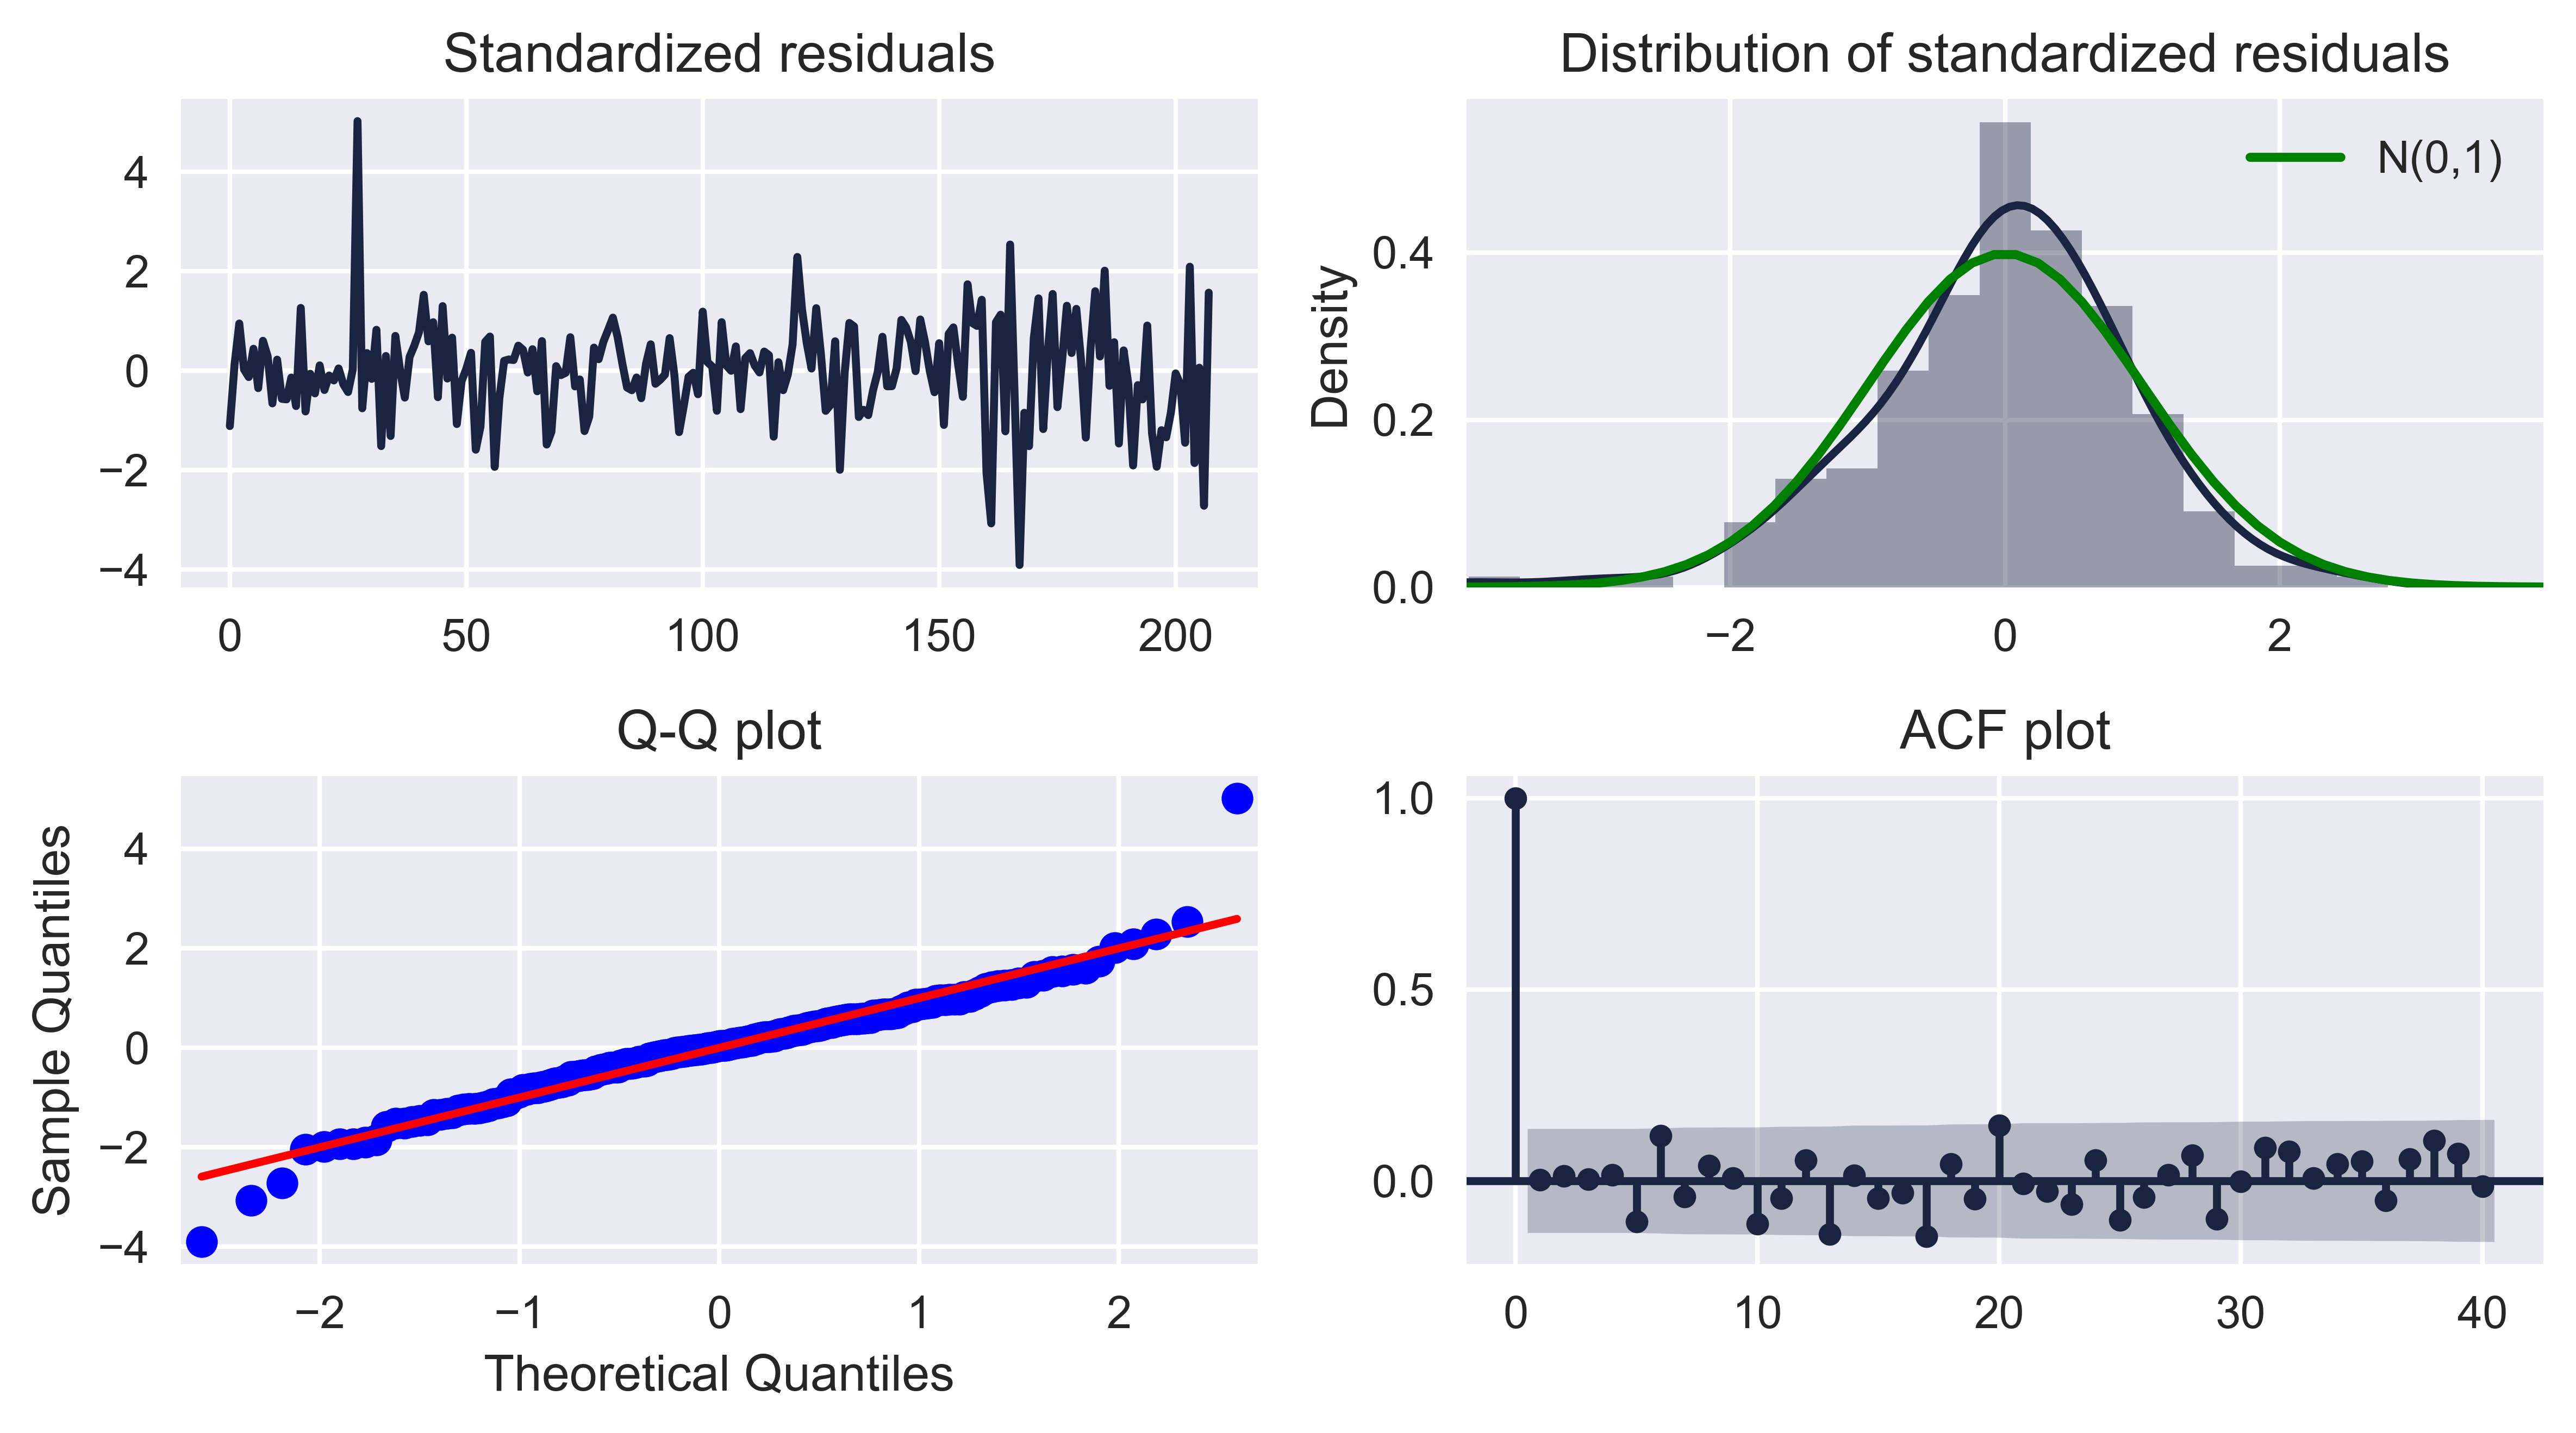

In [51]:
arima_diagnostics(arima.resid, 40)

plt.tight_layout()
plt.show()

8. Apply the Ljung-Box's test for no autocorrelation in the residuals and plot the results:

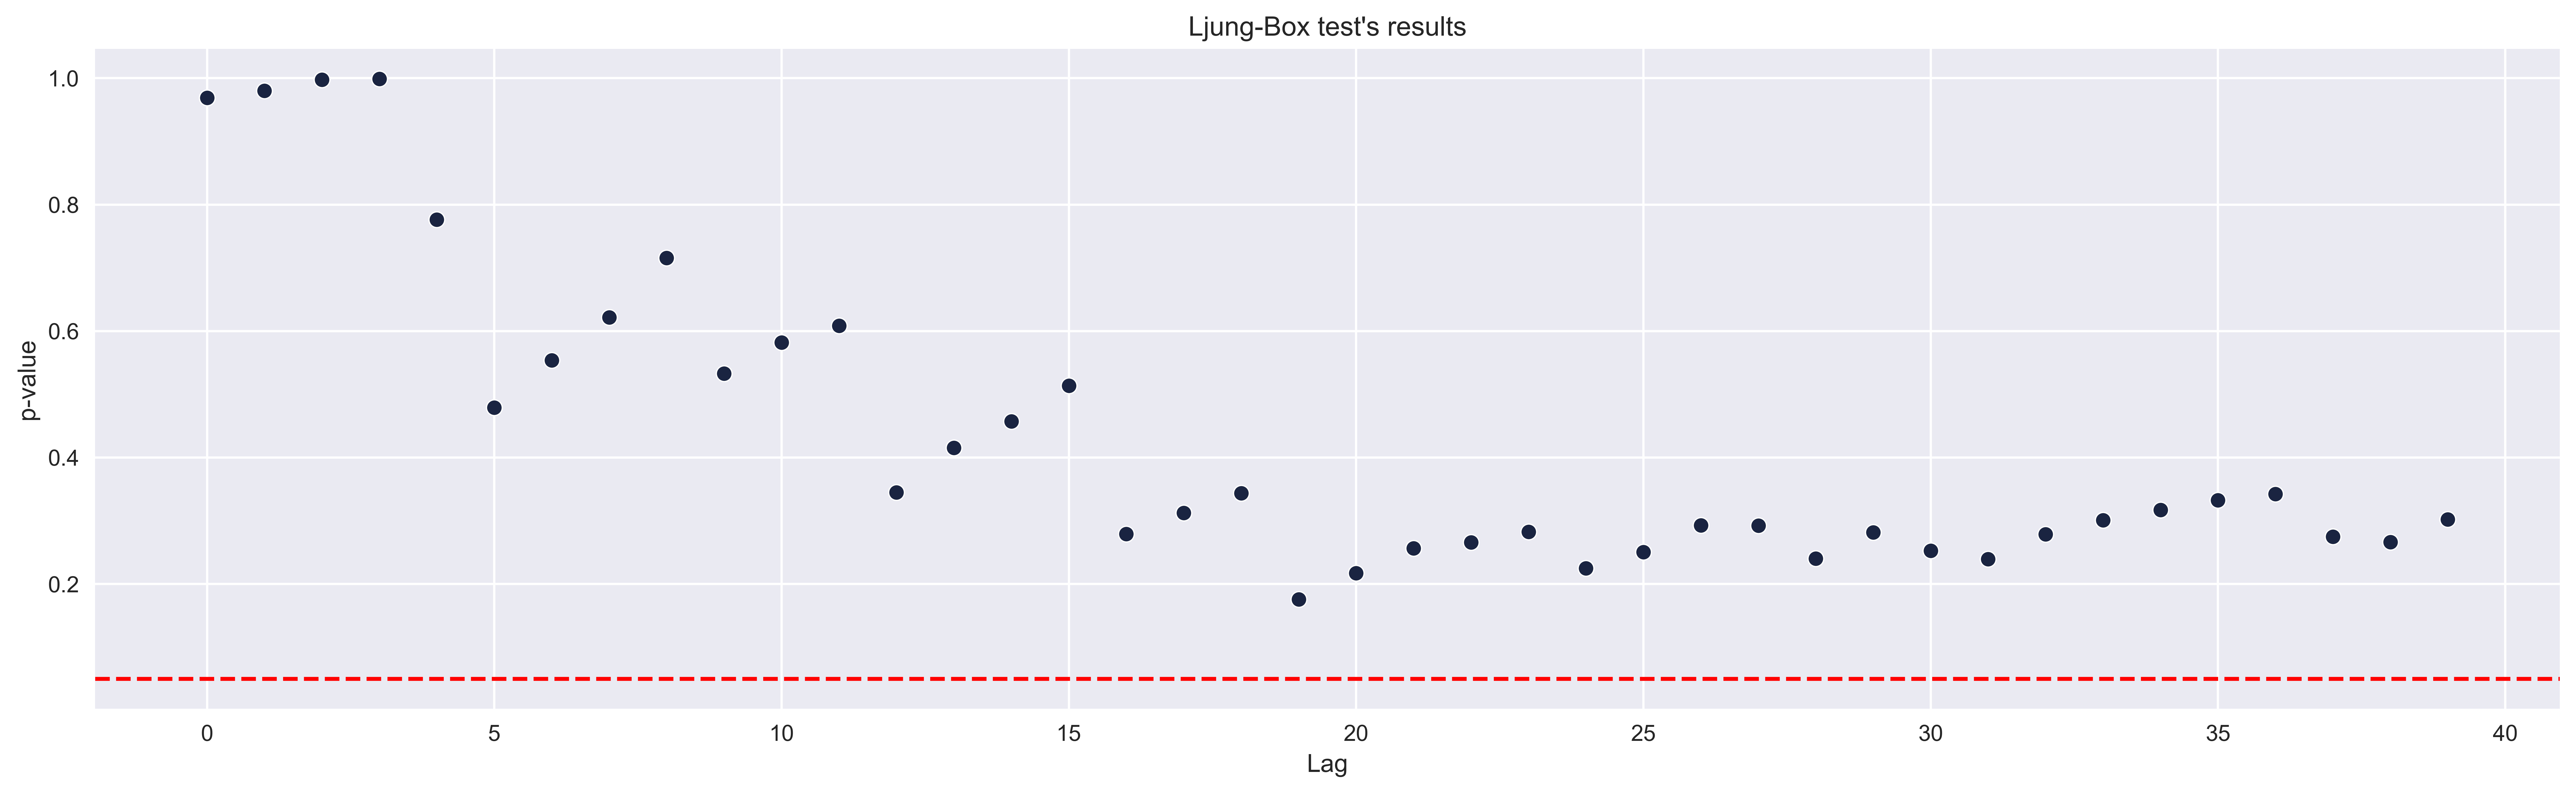

In [52]:
ljung_box_results = acorr_ljungbox(arima.resid)

fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])), 
                y=ljung_box_results[1], 
                ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results",
       xlabel='Lag',
       ylabel='p-value')

plt.tight_layout()
#plt.savefig('images/ch3_im22.png')
plt.show()

### There's more

1. We start by importing the library:

In [54]:
!pip install pmdarima

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\cti110016\\Anaconda3\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2


In [56]:
import pmdarima as pm

ModuleNotFoundError: No module named 'pmdarima'

2. We run `auto_arima` with the majority of settings set to default values. We only exclude potential seasonality.

In [ ]:
auto_arima = pm.auto_arima(goog, 
                          error_action='ignore',
                          suppress_warnings=True,
                          seasonal=False)
auto_arima.summary()

3. In the next step we try to tune the search of the optimal parameters:

In [ ]:
auto_arima = pm.auto_arima(goog,
                          error_action='ignore',
                          suppress_warnings=True,
                          seasonal=False,
                          stepwise=False,
                          approximation=False,
                          n_jobs=-1)
auto_arima.summary()

## Forecasting using ARIMA class models

1. Download additional test data and resample to weekly:

In [ ]:
df = yf.download('GOOG',
                start='2019-01-01',
                end='2019-03-31',
                adjusted=True,
                progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

test = df.resample('W') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close

2. Obtain forecasts from the first model and store them in a DataFrame:

In [ ]:
n_forecasts = len(test)

arima_pred = arima.forecast(n_forecasts)

arima_pred = [pd.DataFrame(arima_pred[0], columns=['prediction']),
             pd.DataFrame(arima_pred[2], columns=['ci_lower', 
                                                 'ci_upper'])]
arima_pred = pd.concat(arima_pred, axis=1).set_index(test.index)

3. Obtain forecasts from the second model and store them in a DataFrame:

In [ ]:
auto_arima_pred = auto_arima.predict(n_periods=n_forecasts, 
                                    return_conf_int=True, 
                                    alpha=0.05)

auto_arima_pred = [pd.DataFrame(auto_arima_pred[0], 
                               columns=['prediction']),
                  pd.DataFrame(auto_arima_pred[1], 
                              columns=['ci_lower', 'ci_upper'])]
auto_arima_pred = pd.concat(auto_arima_pred, 
                           axis=1).set_index(test.index)

4. Plot the results:

In [ ]:
fig, ax = plt.subplots(1)

ax = sns.lineplot(data=test, color=COLORS[0], label='Actual')

ax.plot(arima_pred.prediction, c=COLORS[1], label='ARIMA(2,1,1)')
ax.fill_between(arima_pred.index,
               arima_pred.ci_lower,
               arima_pred.ci_upper,
               alpha=0.3, 
               facecolor=COLORS[1])

ax.plot(auto_arima_pred.prediction, c=COLORS[2], 
       label='ARIMA(3,1,2)')
ax.fill_between(auto_arima_pred.index,
               auto_arima_pred.ci_lower,
               auto_arima_pred.ci_upper,
               alpha=0.2, 
               facecolor=COLORS[2])

ax.set(title="Google's stock price  - actual vs. predicted", 
      xlabel='Date', 
      ylabel='Price ($)')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()